In [17]:
# ==================== PART 0: ENV & INSTALLS ====================

!pip -q install "transformers>=4.40.0" "accelerate" "torch" "timm" "scikit-learn" "pandas" "matplotlib" "huggingface_hub>=0.18.0" "gdown"
!pip -q install "iterative-stratification"

import sys, subprocess
def _safe_import_iterstrat():
    try:
        from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
        return MultilabelStratifiedShuffleSplit
    except ModuleNotFoundError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "iterative-stratification"])
        from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
        return MultilabelStratifiedShuffleSplit

MultilabelStratifiedShuffleSplit = _safe_import_iterstrat()

print("✓ Environment ready. Iterative stratification is available.")


# ==================== PART A: DATA PREPARATION (SAME AS BEFORE) ====================

!gdown 1jEJ2nf5CDJknq80ogzU-Uyz7jbBi-1LZ --fuzzy
!unzip *.zip
!gdown --folder 19yaav8ORSVj9DeJUaHKq1H3HtVnkClBw --remaining-ok

import zipfile
import os
import json
import pandas as pd
import numpy as np
import shutil
from tqdm import tqdm

zip_path = '/kaggle/working/Memotion 3/memotion3.zip'
extract_to = '/kaggle/working/'
password = b'memotion3taskaaai@22'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to, pwd=password)
print(f"Successfully extracted to: {extract_to}")

ORIGINAL_TRAIN_IMG_DIR = '/kaggle/working/trainImages/'
ORIGINAL_CSV_PATH = '/kaggle/working/memotion3/train.csv'
VALIDATION_SPLIT_RATIO = 0.15

OUTPUT_BASE_DIR = '/kaggle/working/'
NEW_VAL_DIR = os.path.join(OUTPUT_BASE_DIR, 'validation_images/')
NEW_TRAIN_DIR = os.path.join(OUTPUT_BASE_DIR, 'new_train_images/')

os.makedirs(NEW_VAL_DIR, exist_ok=True)
os.makedirs(NEW_TRAIN_DIR, exist_ok=True)

print("\nLoading and normalizing CSV file...")
df = pd.read_csv(ORIGINAL_CSV_PATH)

possible_image_cols = ['image_name', 'image', 'img_name', 'filename', 'Unnamed: 0']
IMAGE_FILENAME_COLUMN = next((col for col in possible_image_cols if col in df.columns), df.columns[0])
print(f"\n✅ Detected image column: '{IMAGE_FILENAME_COLUMN}'")

# Normalize labels
for col in ['offensive', 'motivational', 'humour', 'humor', 'sarcastic', 'sarcasm', 'overall', 'sentiment']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.lower().str.strip()

def create_binary_label(value, positive_values):
    if pd.isna(value) or value in ['nan', 'none', '']:
        return 0
    return 1 if value in positive_values else 0

if 'offensive' in df.columns:
    df['offensive_bin'] = df['offensive'].apply(
        lambda x: create_binary_label(x, ['slight', 'very_offensive', 'hateful_offensive'])
    )
else:
    df['offensive_bin'] = 0

if 'motivational' in df.columns:
    df['motivational_bin'] = df['motivational'].apply(
        lambda x: create_binary_label(x, ['motivational'])
    )
else:
    df['motivational_bin'] = 0

if 'humour' in df.columns or 'humor' in df.columns:
    humor_col = 'humour' if 'humour' in df.columns else 'humor'
    df['humor_bin'] = df[humor_col].apply(
        lambda x: create_binary_label(x, ['funny', 'very_funny', 'hilarious'])
    )
else:
    df['humor_bin'] = 0

if 'sarcastic' in df.columns or 'sarcasm' in df.columns:
    sarcasm_col = 'sarcastic' if 'sarcastic' in df.columns else 'sarcasm'
    df['sarcasm_bin'] = df[sarcasm_col].apply(
        lambda x: create_binary_label(x, ['general', 'twisted_meaning', 'very_twisted'])
    )
else:
    df['sarcasm_bin'] = 0

# Stratified split
stratify_columns = ['offensive_bin', 'motivational_bin']

sentiment_col = None
for col in ['overall', 'sentiment', 'overall_sentiment']:
    if col in df.columns:
        sentiment_col = col
        sentiment_map = {
            'very_positive': 0, 'positive': 1, 'neutral': 2, 
            'negative': 3, 'very_negative': 4
        }
        df['sentiment_num'] = df[col].map(sentiment_map).fillna(2).astype(int)
        stratify_columns.append('sentiment_num')
        break

y_stratify = df[stratify_columns].values

msss = MultilabelStratifiedShuffleSplit(
    n_splits=1, 
    test_size=VALIDATION_SPLIT_RATIO, 
    random_state=42
)

train_idx, val_idx = next(msss.split(df, y_stratify))
train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)

print(f"\n📊 Stratified Split Results:")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Calculate label priors
label_priors = {}
label_priors['offensive_pos_rate'] = float(train_df['offensive_bin'].sum() / len(train_df))
label_priors['motivational_pos_rate'] = float(train_df['motivational_bin'].sum() / len(train_df))
label_priors['humor_pos_rate'] = float(train_df['humor_bin'].sum() / len(train_df))
label_priors['sarcasm_pos_rate'] = float(train_df['sarcasm_bin'].sum() / len(train_df))

if sentiment_col:
    sentiment_dist = train_df['sentiment_num'].value_counts().sort_index().to_dict()
    label_priors['sentiment_distribution'] = sentiment_dist
    
    N = len(train_df)
    beta = (N - 1) / N
    
    sentiment_weights = {}
    for class_id, count in sentiment_dist.items():
        effective_num = (1 - beta**count) / (1 - beta)
        sentiment_weights[int(class_id)] = (1 - beta) * N / effective_num
    
    weight_sum = sum(sentiment_weights.values())
    sentiment_weights = {k: v / weight_sum * len(sentiment_weights) 
                        for k, v in sentiment_weights.items()}
    
    label_priors['sentiment_cb_weights'] = sentiment_weights

priors_path = os.path.join(OUTPUT_BASE_DIR, 'label_priors.json')
with open(priors_path, 'w') as f:
    json.dump(label_priors, f, indent=2)
print(f"\n✅ Label priors saved to: {priors_path}")

# Copy images
def copy_images_with_extension(df_subset, dest_dir, source_dir, image_col):
    copied = 0
    missing = 0
    
    for idx in tqdm(df_subset[image_col]):
        filename = str(idx)
        
        if not any(filename.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.gif']):
            for ext in ['.jpg', '.jpeg', '.png']:
                test_path = os.path.join(source_dir, f"{filename}{ext}")
                if os.path.exists(test_path):
                    filename = f"{filename}{ext}"
                    break
            else:
                filename = f"{filename}.jpg"
        
        source_path = os.path.join(source_dir, filename)
        
        if os.path.exists(source_path):
            destination_path = os.path.join(dest_dir, filename)
            shutil.copy(source_path, destination_path)
            copied += 1
        else:
            missing += 1
    
    return copied, missing

print(f"\n📁 Copying images...")
copied_val, missing_val = copy_images_with_extension(
    val_df, NEW_VAL_DIR, ORIGINAL_TRAIN_IMG_DIR, IMAGE_FILENAME_COLUMN
)
copied_train, missing_train = copy_images_with_extension(
    train_df, NEW_TRAIN_DIR, ORIGINAL_TRAIN_IMG_DIR, IMAGE_FILENAME_COLUMN
)

# Save CSVs
new_train_csv_path = os.path.join(OUTPUT_BASE_DIR, 'train_split.csv')
new_val_csv_path = os.path.join(OUTPUT_BASE_DIR, 'validation_split.csv')

train_df.to_csv(new_train_csv_path, index=False)
val_df.to_csv(new_val_csv_path, index=False)

# Create ZIP archives
TRAIN_PACKAGE_DIR = os.path.join(OUTPUT_BASE_DIR, 'training_dataset/')
VAL_PACKAGE_DIR = os.path.join(OUTPUT_BASE_DIR, 'validation_dataset/')

os.makedirs(TRAIN_PACKAGE_DIR, exist_ok=True)
os.makedirs(VAL_PACKAGE_DIR, exist_ok=True)

shutil.copy(new_train_csv_path, os.path.join(TRAIN_PACKAGE_DIR, 'train_split.csv'))
shutil.copytree(NEW_TRAIN_DIR, os.path.join(TRAIN_PACKAGE_DIR, 'new_train_images'), dirs_exist_ok=True)

shutil.copy(new_val_csv_path, os.path.join(VAL_PACKAGE_DIR, 'validation_split.csv'))
shutil.copytree(NEW_VAL_DIR, os.path.join(VAL_PACKAGE_DIR, 'validation_images'), dirs_exist_ok=True)

train_zip_path = shutil.make_archive(
    os.path.join(OUTPUT_BASE_DIR, 'training_dataset'), 'zip', TRAIN_PACKAGE_DIR
)
val_zip_path = shutil.make_archive(
    os.path.join(OUTPUT_BASE_DIR, 'validation_dataset'), 'zip', VAL_PACKAGE_DIR
)

print("\n✅ DATA PREPARATION COMPLETE")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✓ Environment ready. Iterative stratification is available.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading...
From (original): https://drive.google.com/uc?id=1jEJ2nf5CDJknq80ogzU-Uyz7jbBi-1LZ
From (redirected): https://drive.google.com/uc?id=1jEJ2nf5CDJknq80ogzU-Uyz7jbBi-1LZ&confirm=t&uuid=10bae9d1-136e-42a6-a9e7-523b8df51eaa
To: /kaggle/working/trainImages.zip
100%|████████████████████████████████████████| 187M/187M [00:05<00:00, 33.1MB/s]
Archive:  trainImages.zip
caution: filename not matched:  training_dataset.zip
caution: filename not matched:  validation_dataset.zip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Retrieving folder contents
Processing file 12r4t1_kGLPDFilQjq9z-aajTkgfxmKbW format.py
Processing file 1sFYqIKpiUhsnuFDN0rY4wAGKkjiFI2JR memotion3-test.zip
Processing file 1eKS4bGya5SQXP0E9S9iHf0pUUbR0RJJb memotion3-val.zip
Processing file 11TRDmQhPXcwXK3DJIPkXyYBIaL8ard1v memotion3.zip
Processing file 1X_K5hJmYOFO3BlkHJn50UypX0RJ_SYU_ README.txt
Processing file 1Q1I3E00H2L6V2fdV-y5796HKbzas2vxF testImages.zip
Processing file 1jEJ2nf5CDJknq80ogzU-Uyz7jbBi-1LZ trainImages.zip
Processing file 189yDwbXt0fdhz-Zm4bKSlL3-E6M74kKl valImages.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=12r4t1_kGLPDFilQjq9z-aajTkgfxmKbW
From (redirected): https://drive.google.com/uc?id=12r4t1_kGLPDFilQjq9z-aajTkgfxmKbW&confirm=t&uuid=44cb5fe7-6e73-4def-b47e-9f26bbbfc454
To: /kaggle/working/Memotion 3/format.py
100%|██████████████████████████████████████| 1.81k/1.81k [00:00<00:00, 8.77MB

100%|██████████| 5950/5950 [00:01<00:00, 5775.69it/s]



✅ DATA PREPARATION COMPLETE


In [18]:
# ==================== PART 1: CONFIGURATION WITH ORDINAL REGRESSION ====================

import random
import yaml
from typing import Dict, List, Tuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import GradScaler, autocast

from transformers import AutoModel, AutoTokenizer, CLIPModel
import torchvision.transforms as transforms
from PIL import Image

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, 
    mean_squared_error, mean_absolute_error, confusion_matrix, 
    classification_report, average_precision_score, f1_score,
    precision_score, recall_score
)
from scipy.stats import spearmanr

print("✓ All imports successful")

# Load label priors
PRIORS_PATH = '/kaggle/working/label_priors.json'
with open(PRIORS_PATH, 'r') as f:
    LABEL_PRIORS = json.load(f)

print(f"✓ Loaded label priors from {PRIORS_PATH}")

# Configuration with Ordinal Regression
CONFIG = f"""
# Multi-modal Fusion Configuration with Ordinal Regression

# Model Architecture
TEXT_MODEL: "google/muril-base-cased"
IMAGE_MODEL: "openai/clip-vit-base-patch32"
TEXT_DIM: 768
IMAGE_DIM: 768
FUSION_DIM: 512
FUSION_OUT_DIM: 512

# Training Parameters
MAX_LEN: 128
IMG_SIZE: 224
BATCH_SIZE: 16
GRADIENT_ACCUMULATION_STEPS: 2
LR_HEADS: 0.001
LR_BACKBONE: 0.00001
WEIGHT_DECAY: 0.01
EPOCHS: 5
SEED: 42
DEVICE: "cuda"
CHECKPOINT_PATH: "/kaggle/working/checkpoints"

# Task Configuration
NUM_SENTIMENT_CLASSES: 5
NUM_EMOTION_CLASSES: 4

# Ordinal Regression for Sentiment
USE_ORDINAL_REGRESSION: true
ORDINAL_LINK: "logit"  # logit or probit
NUM_ORDINAL_THRESHOLDS: 4  # K-1 thresholds for K=5 classes

# Loss Weights
LOSS_WEIGHTS:
  sentiment: 2.0  # Increased weight for ordinal sentiment
  emotion: 1.0
  intensity: 0.5

# ASL Hyperparameters for Emotions
ASL_GAMMA_NEG: 6.0
ASL_GAMMA_POS: 0.0
ASL_CLIP: 0.05

# Emotion Priors
EMO_PRIORS: [{LABEL_PRIORS['humor_pos_rate']}, {LABEL_PRIORS['sarcasm_pos_rate']}, {LABEL_PRIORS['offensive_pos_rate']}, {LABEL_PRIORS['motivational_pos_rate']}]

# Emotion Thresholds
EMO_THRESHOLDS: [0.5, 0.5, 0.60, 0.60]

# Precision Targets
PRECISION_TARGETS:
  humor: 0.70
  sarcasm: 0.70
  offensive: 0.75
  motivational: 0.60

# Training Strategy
POOLING: "mean"
USE_AMP: true
GRADIENT_CLIP: 1.0
SCHEDULER: "cosine"
WARMUP_EPOCHS: 1
UNFREEZE_BACKBONE_EPOCH: 2

# Cross-Attention
CROSS_ATTN_HEADS: 8
CROSS_ATTN_DROPOUT: 0.1

# Oversampling
MOTIVATIONAL_OVERSAMPLE_FACTOR: 5.0
"""

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"✓ Random seed set to {seed}")

def load_config(config_str: str) -> dict:
    cfg = yaml.safe_load(config_str)
    print("✓ Configuration loaded")
    return cfg

def save_checkpoint(state: dict, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(state, path)
    print(f"✓ Checkpoint saved to {path}")

def get_tokenizer(cfg: dict):
    tokenizer = AutoTokenizer.from_pretrained(cfg['TEXT_MODEL'])
    print(f"✓ Tokenizer loaded: {cfg['TEXT_MODEL']}")
    return tokenizer

def get_image_transform(cfg: dict, is_train: bool = True):
    if is_train:
        transform = transforms.Compose([
            transforms.Resize((cfg['IMG_SIZE'], cfg['IMG_SIZE'])),
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48145466, 0.4578275, 0.40821073],
                std=[0.26862954, 0.26130258, 0.27577711]
            )
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((cfg['IMG_SIZE'], cfg['IMG_SIZE'])),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48145466, 0.4578275, 0.40821073],
                std=[0.26862954, 0.26130258, 0.27577711]
            )
        ])
    print(f"✓ Image transform created (train={is_train})")
    return transform

# Initialize configuration
cfg = load_config(CONFIG)
set_seed(cfg['SEED'])

device = torch.device(cfg['DEVICE'] if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

print("\n" + "="*70)
print("Part 1 Complete - Configuration with Ordinal Regression Loaded")
print("="*70)
print("\nKey Feature: Ordinal Regression for Sentiment")
print("  - Uses cumulative link model (proportional odds)")
print("  - Respects ordinal nature: very_negative < negative < neutral < positive < very_positive")
print("  - 4 learnable threshold parameters for 5 classes")

✓ All imports successful
✓ Loaded label priors from /kaggle/working/label_priors.json
✓ Configuration loaded
✓ Random seed set to 42
✓ Using device: cuda
  GPU: Tesla P100-PCIE-16GB

Part 1 Complete - Configuration with Ordinal Regression Loaded

Key Feature: Ordinal Regression for Sentiment
  - Uses cumulative link model (proportional odds)
  - Respects ordinal nature: very_negative < negative < neutral < positive < very_positive
  - 4 learnable threshold parameters for 5 classes


In [19]:
# ==================== PART 2: DATASET CLASS ====================

def prepare_data(cfg):
    """Extract and prepare dataset"""
    print("Preparing datasets...")
    
    train_dir = '/kaggle/working/train'
    val_dir = '/kaggle/working/val'
    
    if not os.path.exists(train_dir):
        print("Extracting training dataset...")
        with zipfile.ZipFile('/kaggle/working/training_dataset.zip', 'r') as zip_ref:
            zip_ref.extractall('/kaggle/working/train')
    else:
        print("✓ Training dataset already extracted")
    
    if not os.path.exists(val_dir):
        print("Extracting validation dataset...")
        with zipfile.ZipFile('/kaggle/working/validation_dataset.zip', 'r') as zip_ref:
            zip_ref.extractall('/kaggle/working/val')
    else:
        print("✓ Validation dataset already extracted")
    
    # Find CSV files
    train_csv = None
    val_csv = None
    
    for root, dirs, files in os.walk(train_dir):
        for file in files:
            if file.endswith('.csv'):
                train_csv = os.path.join(root, file)
                break
        if train_csv:
            break
    
    for root, dirs, files in os.walk(val_dir):
        for file in files:
            if file.endswith('.csv'):
                val_csv = os.path.join(root, file)
                break
        if val_csv:
            break
    
    if train_csv is None or val_csv is None:
        raise FileNotFoundError("Could not find CSV files")
    
    print(f"✓ Loading training data from {train_csv}")
    train_df = pd.read_csv(train_csv)
    
    print(f"✓ Loading validation data from {val_csv}")
    val_df = pd.read_csv(val_csv)
    
    # Find image directories
    train_img_dir = None
    val_img_dir = None
    
    for root, dirs, files in os.walk(train_dir):
        img_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))]
        if img_files:
            train_img_dir = root
            break
    
    for root, dirs, files in os.walk(val_dir):
        img_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))]
        if img_files:
            val_img_dir = root
            break
    
    if train_img_dir is None or val_img_dir is None:
        raise FileNotFoundError("Could not find image directories")
    
    print(f"\n{'='*70}")
    print(f"Dataset Information:")
    print(f"  Train Samples: {len(train_df)}")
    print(f"  Val Samples: {len(val_df)}")
    print(f"{'='*70}\n")
    
    return train_df, val_df, train_img_dir, val_img_dir


class MemeDataset(Dataset):
    """Enhanced Dataset for meme sentiment and emotion analysis"""
    
    def __init__(self, df: pd.DataFrame, tokenizer, image_transform, 
                 image_dir: str, cfg: dict):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.image_dir = image_dir
        self.cfg = cfg
        
        self._detect_columns()
        print(f"✓ Dataset initialized with {len(self.df)} samples")
    
    def _detect_columns(self):
        """Detect column names in the dataframe"""
        cols = self.df.columns.tolist()
        
        # Image column
        possible_image_cols = ['image_name', 'image', 'img_name', 'filename', 'image_id', 'Unnamed: 0']
        self.image_col = next((col for col in possible_image_cols if col in cols), cols[0])
        
        # Text column
        possible_text_cols = ['text', 'ocr_text', 'caption', 'extracted_text', 'OCR_extracted_text', 'ocr']
        self.text_col = next((col for col in possible_text_cols if col in cols), None)
        
        # Sentiment column
        possible_sentiment_cols = ['sentiment', 'overall_sentiment', 'sentiment_label', 'overall']
        self.sentiment_col = next((col for col in possible_sentiment_cols if col in cols), None)
        
        print(f"  Detected columns - Image: {self.image_col}, Text: {self.text_col}, Sentiment: {self.sentiment_col}")
        
        self._create_label_mappings()
    
    def _create_label_mappings(self):
        """Create mappings for string labels to numeric values"""
        # Sentiment mapping (5 classes - ORDINAL)
        self.sentiment_map = {
            'very_positive': 0,
            'positive': 1,
            'neutral': 2,
            'negative': 3,
            'very_negative': 4
        }
        
        # Emotion mappings (binary)
        self.humor_map = {
            'not_funny': 0,
            'funny': 1,
            'very_funny': 1,
            'hilarious': 1
        }
        
        self.sarcasm_map = {
            'not_sarcastic': 0,
            'general': 1,
            'twisted_meaning': 1,
            'very_twisted': 1
        }
        
        self.offensive_map = {
            'not_offensive': 0,
            'slight': 1,
            'very_offensive': 1,
            'hateful_offensive': 1
        }
        
        self.motivational_map = {
            'not_motivational': 0,
            'motivational': 1
        }
    
    def _map_label(self, value, mapping, default=0):
        """Map string label to numeric value"""
        if pd.isna(value):
            return default
        if isinstance(value, str):
            return mapping.get(value.lower().strip(), default)
        try:
            return int(value)
        except:
            return default
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int) -> Dict:
        row = self.df.iloc[idx]
        
        # Load image
        image_name = row[self.image_col] if self.image_col else f"{idx}.jpg"
        
        if isinstance(image_name, (int, float)):
            image_name = f"{int(image_name)}.jpg"
        else:
            image_name = str(image_name)
        
        if not any(image_name.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.gif']):
            image_name = f"{image_name}.jpg"
        
        image_path = os.path.join(self.image_dir, image_name)
        
        try:
            image = Image.open(image_path).convert('RGB')
            image = self.image_transform(image)
        except Exception as e:
            image = torch.zeros(3, self.cfg['IMG_SIZE'], self.cfg['IMG_SIZE'])
        
        # Tokenize text
        text = str(row.get(self.text_col, '')) if self.text_col else ''
        if text in ['nan', '', 'None'] or text is None:
            text = 'No text available'
        
        encoding = self.tokenizer(
            text,
            max_length=self.cfg['MAX_LEN'],
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Get sentiment label (ordinal: 0=very_positive ... 4=very_negative)
        sentiment_label = 2  # default neutral
        if self.sentiment_col and self.sentiment_col in row:
            sent_val = row[self.sentiment_col]
            sentiment_label = self._map_label(sent_val, self.sentiment_map, default=2)
        sentiment_label = torch.tensor(sentiment_label, dtype=torch.long)
        
        # Get emotion labels (multi-label binary)
        humor_val = row.get('humour', row.get('humor', 0))
        sarcasm_val = row.get('sarcastic', row.get('sarcasm', 0))
        offensive_val = row.get('offensive', 0)
        motivational_val = row.get('motivational', 0)
        
        emotion_labels = torch.tensor([
            float(self._map_label(humor_val, self.humor_map, default=0)),
            float(self._map_label(sarcasm_val, self.sarcasm_map, default=0)),
            float(self._map_label(offensive_val, self.offensive_map, default=0)),
            float(self._map_label(motivational_val, self.motivational_map, default=0))
        ], dtype=torch.float)
        
        # Get intensity score
        intensity_val = row.get('overall_sentiment', row.get('overall', 0.0))
        if isinstance(intensity_val, str):
            intensity_score_map = {
                'very_positive': 1.0,
                'positive': 0.75,
                'neutral': 0.5,
                'negative': 0.25,
                'very_negative': 0.0
            }
            intensity_val = intensity_score_map.get(intensity_val.lower().strip(), 0.5)
        
        intensity = torch.tensor(
            float(intensity_val) if not pd.isna(intensity_val) else 0.5, 
            dtype=torch.float
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'image': image,
            'sentiment_label': sentiment_label,
            'emotion_labels': emotion_labels,
            'intensity': intensity,
            'motivational_flag': emotion_labels[3]  # For weighted sampling
        }


def collate_fn(batch: List[Dict]):
    """Collate function for batching"""
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'image': torch.stack([item['image'] for item in batch]),
        'sentiment_label': torch.stack([item['sentiment_label'] for item in batch]),
        'emotion_labels': torch.stack([item['emotion_labels'] for item in batch]),
        'intensity': torch.stack([item['intensity'] for item in batch])
    }


# Prepare data
try:
    train_df, val_df, train_img_dir, val_img_dir = prepare_data(cfg)
    
    print("\n" + "="*70)
    print("Part 2 Complete - Dataset preparation successful")
    print("="*70)
except Exception as e:
    print(f"\n✗ Error in data preparation: {e}")
    import traceback
    traceback.print_exc()

Preparing datasets...
✓ Training dataset already extracted
✓ Validation dataset already extracted
✓ Loading training data from /kaggle/working/train/train_split.csv
✓ Loading validation data from /kaggle/working/val/validation_split.csv

Dataset Information:
  Train Samples: 5950
  Val Samples: 1050


Part 2 Complete - Dataset preparation successful


In [20]:
# ==================== PART 3: MODEL WITH ORDINAL REGRESSION ====================

class CrossAttentionFusion(nn.Module):
    """Bidirectional cross-attention between text and image modalities"""
    
    def __init__(self, dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        
        self.text_to_image_attn = nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        
        self.image_to_text_attn = nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        
        self.text_norm = nn.LayerNorm(dim)
        self.image_norm = nn.LayerNorm(dim)
        
        self.text_ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )
        
        self.image_ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )
        
        self.ffn_norm_text = nn.LayerNorm(dim)
        self.ffn_norm_image = nn.LayerNorm(dim)
    
    def forward(self, text_emb, image_emb):
        text_seq = text_emb.unsqueeze(1)
        image_seq = image_emb.unsqueeze(1)
        
        text_attended, _ = self.text_to_image_attn(
            query=text_seq, key=image_seq, value=image_seq
        )
        text_attended = text_attended.squeeze(1)
        text_out = self.text_norm(text_emb + text_attended)
        
        image_attended, _ = self.image_to_text_attn(
            query=image_seq, key=text_seq, value=text_seq
        )
        image_attended = image_attended.squeeze(1)
        image_out = self.image_norm(image_emb + image_attended)
        
        text_ffn_out = self.text_ffn(text_out)
        text_final = self.ffn_norm_text(text_out + text_ffn_out)
        
        image_ffn_out = self.image_ffn(image_out)
        image_final = self.ffn_norm_image(image_out + image_ffn_out)
        
        return text_final, image_final


class OrdinalRegressionHead(nn.Module):
    """
    Ordinal Regression Head using Cumulative Link Model
    
    For K classes (0, 1, ..., K-1), we learn K-1 thresholds
    P(Y <= k) = σ(threshold_k - f(x))
    
    where f(x) is the projected feature
    """
    
    def __init__(self, input_dim, num_classes, link='logit'):
        super().__init__()
        self.num_classes = num_classes
        self.num_thresholds = num_classes - 1
        self.link = link
        
        # Project features to a single score
        self.projection = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )
        
        # Learnable thresholds (K-1 thresholds for K classes)
        # Initialize with reasonable spacing
        initial_thresholds = torch.linspace(-2, 2, self.num_thresholds)
        self.thresholds = nn.Parameter(initial_thresholds)
    
    def forward(self, x):
        """
        Args:
            x: Input features (batch_size, input_dim)
        
        Returns:
            logits: Cumulative logits (batch_size, num_classes-1)
            class_probs: Class probabilities (batch_size, num_classes)
        """
        # Project to single score
        score = self.projection(x).squeeze(-1)  # (batch_size,)
        
        # Ensure thresholds are ordered (enforce monotonicity)
        # Use cumsum of softplus to maintain order
        ordered_thresholds = torch.cumsum(
            F.softplus(self.thresholds), dim=0
        )
        
        # Compute cumulative logits: threshold - score
        # Shape: (batch_size, num_thresholds)
        cumulative_logits = ordered_thresholds.unsqueeze(0) - score.unsqueeze(1)
        
        # Apply link function (sigmoid for logit link)
        if self.link == 'logit':
            cumulative_probs = torch.sigmoid(cumulative_logits)
        else:  # probit link
            from torch.distributions import Normal
            cumulative_probs = Normal(0, 1).cdf(cumulative_logits)
        
        # Convert cumulative probabilities to class probabilities
        # P(Y = 0) = P(Y <= 0)
        # P(Y = k) = P(Y <= k) - P(Y <= k-1) for k > 0
        # P(Y = K-1) = 1 - P(Y <= K-2)
        
        batch_size = cumulative_probs.size(0)
        class_probs = torch.zeros(batch_size, self.num_classes, device=x.device)
        
        # First class
        class_probs[:, 0] = cumulative_probs[:, 0]
        
        # Middle classes
        for k in range(1, self.num_thresholds):
            class_probs[:, k] = cumulative_probs[:, k] - cumulative_probs[:, k-1]
        
        # Last class
        class_probs[:, -1] = 1.0 - cumulative_probs[:, -1]
        
        # Clamp to avoid numerical issues
        class_probs = torch.clamp(class_probs, min=1e-7, max=1.0)
        
        return cumulative_logits, class_probs


class EnhancedFusionModelWithOrdinal(nn.Module):
    """Multi-modal fusion model with Ordinal Regression for Sentiment"""
    
    def __init__(self, cfg: dict):
        super().__init__()
        self.cfg = cfg
        
        print(f"Loading text model: {cfg['TEXT_MODEL']}")
        self.text_model = AutoModel.from_pretrained(cfg['TEXT_MODEL'])
        
        print(f"Loading image model: {cfg['IMAGE_MODEL']}")
        clip_model = CLIPModel.from_pretrained(cfg['IMAGE_MODEL'])
        self.image_model = clip_model.vision_model
        
        self._freeze_encoders()
        
        # Projection layers
        self.text_proj = nn.Linear(cfg['TEXT_DIM'], cfg['FUSION_DIM'])
        self.image_proj = nn.Linear(cfg['IMAGE_DIM'], cfg['FUSION_DIM'])
        
        nn.init.xavier_uniform_(self.text_proj.weight)
        nn.init.zeros_(self.text_proj.bias)
        nn.init.xavier_uniform_(self.image_proj.weight)
        nn.init.zeros_(self.image_proj.bias)
        
        # Cross-Attention Fusion
        self.cross_attention = CrossAttentionFusion(
            dim=cfg['FUSION_DIM'],
            num_heads=cfg['CROSS_ATTN_HEADS'],
            dropout=cfg['CROSS_ATTN_DROPOUT']
        )
        
        # Final fusion MLP
        fusion_input_dim = cfg['FUSION_DIM'] * 2
        self.fusion_norm = nn.LayerNorm(fusion_input_dim)
        self.fusion_mlp = nn.Sequential(
            nn.Linear(fusion_input_dim, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, cfg['FUSION_OUT_DIM']),
            nn.LayerNorm(cfg['FUSION_OUT_DIM'])
        )
        
        # Task-specific heads
        if cfg.get('USE_ORDINAL_REGRESSION', False):
            print("✓ Using Ordinal Regression Head for Sentiment")
            self.sentiment_head = OrdinalRegressionHead(
                input_dim=cfg['FUSION_OUT_DIM'],
                num_classes=cfg['NUM_SENTIMENT_CLASSES'],
                link=cfg.get('ORDINAL_LINK', 'logit')
            )
        else:
            print("✓ Using Standard Classification Head for Sentiment")
            self.sentiment_head = nn.Sequential(
                nn.Linear(cfg['FUSION_OUT_DIM'], 256),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(256, cfg['NUM_SENTIMENT_CLASSES'])
            )
        
        self.emotion_head = nn.Sequential(
            nn.Linear(cfg['FUSION_OUT_DIM'], 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, cfg['NUM_EMOTION_CLASSES'])
        )
        
        self.intensity_head = nn.Sequential(
            nn.Linear(cfg['FUSION_OUT_DIM'], 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
        
        print("✓ Enhanced model with Ordinal Regression initialized")
    
    def _freeze_encoders(self):
        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.image_model.parameters():
            param.requires_grad = False
        print("✓ Encoders frozen")
    
    def unfreeze_backbone(self, layers_to_unfreeze: int = 2):
        if hasattr(self.text_model, 'encoder') and hasattr(self.text_model.encoder, 'layer'):
            text_layers = list(self.text_model.encoder.layer[-layers_to_unfreeze:])
            for layer in text_layers:
                for param in layer.parameters():
                    param.requires_grad = True
            print(f"✓ Unfroze {layers_to_unfreeze} text encoder layers")
        
        if hasattr(self.image_model, 'encoder') and hasattr(self.image_model.encoder, 'layers'):
            image_layers = list(self.image_model.encoder.layers[-layers_to_unfreeze:])
            for layer in image_layers:
                for param in layer.parameters():
                    param.requires_grad = True
            print(f"✓ Unfroze {layers_to_unfreeze} image encoder layers")
    
    def pool_text(self, model_output, attention_mask):
        last_hidden = model_output.last_hidden_state
        if self.cfg['POOLING'] == 'cls':
            return last_hidden[:, 0]
        elif self.cfg['POOLING'] == 'mean':
            mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
            sum_embeddings = torch.sum(last_hidden * mask_expanded, 1)
            sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
            return sum_embeddings / sum_mask
        else:
            return last_hidden[:, 0]
    
    def forward(self, input_ids, attention_mask, image):
        # Text encoding
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = self.pool_text(text_output, attention_mask)
        
        # Image encoding
        image_output = self.image_model(pixel_values=image)
        image_emb = image_output.pooler_output
        
        # Project to common dimension
        text_proj = self.text_proj(text_emb)
        image_proj = self.image_proj(image_emb)
        
        # Cross-Attention Fusion
        text_cross, image_cross = self.cross_attention(text_proj, image_proj)
        
        # Concatenate and fuse
        fused = torch.cat([text_cross, image_cross], dim=1)
        fused = self.fusion_norm(fused)
        fused = self.fusion_mlp(fused)
        
        # Task predictions
        if self.cfg.get('USE_ORDINAL_REGRESSION', False):
            cumulative_logits, sentiment_probs = self.sentiment_head(fused)
            sentiment_outputs = {
                'cumulative_logits': cumulative_logits,
                'class_probs': sentiment_probs
            }
        else:
            sentiment_logits = self.sentiment_head(fused)
            sentiment_outputs = {'logits': sentiment_logits}
        
        emotion_logits = self.emotion_head(fused)
        intensity = self.intensity_head(fused).squeeze(-1)
        
        return {
            'sentiment': sentiment_outputs,
            'emotion_logits': emotion_logits,
            'intensity': intensity,
            'text_features': text_cross,
            'image_features': image_cross
        }


# Initialize model
try:
    print("\nInitializing Enhanced Model with Ordinal Regression...")
    model = EnhancedFusionModelWithOrdinal(cfg).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n{'='*70}")
    print("Model Summary:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Frozen parameters: {total_params - trainable_params:,}")
    print(f"{'='*70}")
    
    print("\n" + "="*70)
    print("Part 3 Complete - Model with Ordinal Regression initialized")
    print("="*70)
    
except Exception as e:
    print(f"\n✗ Error in model initialization: {e}")
    import traceback
    traceback.print_exc()


Initializing Enhanced Model with Ordinal Regression...
Loading text model: google/muril-base-cased
Loading image model: openai/clip-vit-base-patch32
✓ Encoders frozen
✓ Using Ordinal Regression Head for Sentiment
✓ Enhanced model with Ordinal Regression initialized

Model Summary:
  Total parameters: 333,224,714
  Trainable parameters: 8,212,490
  Frozen parameters: 325,012,224

Part 3 Complete - Model with Ordinal Regression initialized


In [21]:
# ==================== PART 4: LOSS FUNCTIONS WITH ORDINAL REGRESSION (UPDATED) ====================

import torch
import torch.nn as nn
import torch.nn.functional as F

# Device (add this at the top)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class AsymmetricLoss(nn.Module):
    """Asymmetric Loss (ASL) for multi-label classification"""
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8):
        super(AsymmetricLoss, self).__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps
    
    def forward(self, logits, targets):
        xs_pos = torch.sigmoid(logits)
        xs_neg = 1 - xs_pos
        
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)
        
        los_pos = targets * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - targets) * torch.log(xs_neg.clamp(min=self.eps))
        
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            pt0 = xs_pos * targets
            pt1 = xs_neg * (1 - targets)
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * targets + self.gamma_neg * (1 - targets)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            loss = one_sided_w * (los_pos + los_neg)
        else:
            loss = los_pos + los_neg
        
        return -loss.mean()


def ordinal_regression_loss(cumulative_logits, labels):
    """
    Ordinal Regression Loss using cumulative link model
    
    Args:
        cumulative_logits: (batch_size, K-1) cumulative logits
        labels: (batch_size,) class labels in range [0, K-1]
    
    Returns:
        loss: scalar loss value
    """
    batch_size = labels.size(0)
    num_thresholds = cumulative_logits.size(1)
    num_classes = num_thresholds + 1
    
    # Create target cumulative probabilities
    # For label y, we want:
    # P(Y <= k) = 1 if k >= y
    # P(Y <= k) = 0 if k < y
    target_cumulative = torch.zeros_like(cumulative_logits, device=cumulative_logits.device)
    for i in range(batch_size):
        y = int(labels[i].item())
        # thresholds >= y => 1. For y == num_classes-1 (last class), nothing to set (all zeros -> handled by BCE)
        if y < num_classes - 1:
            target_cumulative[i, y:] = 1.0
    
    # Binary cross-entropy on cumulative probabilities (with logits)
    loss = F.binary_cross_entropy_with_logits(
        cumulative_logits, 
        target_cumulative,
        reduction='mean'
    )
    
    return loss


def sentiment_loss_fn_ordinal(sentiment_outputs, labels, cfg):
    """
    Sentiment loss using ordinal regression
    """
    if cfg.get('USE_ORDINAL_REGRESSION', False):
        cumulative_logits = sentiment_outputs['cumulative_logits']
        loss = ordinal_regression_loss(cumulative_logits, labels)
    else:
        # Fallback to standard cross-entropy
        logits = sentiment_outputs['logits']
        weights = cfg.get('SENTIMENT_CB_WEIGHTS', {i: 1.0 for i in range(cfg.get('NUM_SENTIMENT_CLASSES', 5))})
        weight_tensor = torch.tensor(
            [weights[i] for i in range(cfg.get('NUM_SENTIMENT_CLASSES', logits.size(-1)))],
            device=logits.device,
            dtype=torch.float
        )
        loss = F.cross_entropy(logits, labels, weight=weight_tensor)
    
    return loss


def adjust_logits_with_priors(logits, priors, tau=1.0):
    """Adjust logits based on training priors"""
    if isinstance(priors, list):
        priors = torch.tensor(priors, device=logits.device)
    
    adjustment = tau * torch.log(priors.clamp(min=1e-8))
    adjusted_logits = logits - adjustment
    
    return adjusted_logits


def emotion_loss_fn(logits, labels, cfg):
    """Emotion classification loss using ASL with prior adjustment"""
    priors = cfg.get('EMO_PRIORS', [0.5] * cfg.get('NUM_EMOTION_CLASSES', 4))
    adjusted_logits = adjust_logits_with_priors(logits, priors, tau=1.0)
    
    asl = AsymmetricLoss(
        gamma_neg=cfg.get('ASL_GAMMA_NEG', 4.0),
        gamma_pos=cfg.get('ASL_GAMMA_POS', 0.0),
        clip=cfg.get('ASL_CLIP', 0.05)
    )
    
    loss = asl(adjusted_logits, labels)
    
    return loss


def intensity_loss_fn(preds, targets, cfg):
    """Intensity regression loss"""
    return F.smooth_l1_loss(preds, targets)


def combined_loss(outputs, batch, cfg):
    """Combined multi-task loss"""
    loss_sent = sentiment_loss_fn_ordinal(outputs['sentiment'], batch['sentiment_label'], cfg)
    loss_emotion = emotion_loss_fn(outputs['emotion_logits'], batch['emotion_labels'], cfg)
    loss_intensity = intensity_loss_fn(outputs['intensity'], batch['intensity'], cfg)
    
    total_loss = (
        cfg['LOSS_WEIGHTS']['sentiment'] * loss_sent +
        cfg['LOSS_WEIGHTS']['emotion'] * loss_emotion +
        cfg['LOSS_WEIGHTS']['intensity'] * loss_intensity
    )
    
    return total_loss, loss_sent, loss_emotion, loss_intensity


# ----------------- TEST LOSS COMPUTATION (robust when model/cfg missing) -----------------
print("\nTesting Ordinal Regression Loss...")

# Safety: require cfg to exist; otherwise create a minimal test cfg
if 'cfg' not in globals():
    print("⚠ cfg not found in kernel: creating a minimal test cfg for loss checks (won't be used for training).")
    cfg = {
        'USE_ORDINAL_REGRESSION': True,
        'NUM_SENTIMENT_CLASSES': 5,
        'NUM_EMOTION_CLASSES': 4,
        'MAX_LEN': 128,
        'IMG_SIZE': 224,
        'LOSS_WEIGHTS': {'sentiment': 1.0, 'emotion': 1.0, 'intensity': 1.0},
        'ASL_GAMMA_NEG': 4.0,
        'ASL_GAMMA_POS': 0.0,
        'ASL_CLIP': 0.05,
        'SENTIMENT_CB_WEIGHTS': {i: 1.0 for i in range(5)}
    }

try:
    # Create dummy data shapes (batch_size = 4)
    batch_size = 4
    dummy_input_ids = torch.randint(0, 1000, (batch_size, cfg.get('MAX_LEN', 128))).to(device)
    dummy_attention_mask = torch.ones(batch_size, cfg.get('MAX_LEN', 128)).to(device)
    dummy_image = torch.randn(batch_size, 3, cfg.get('IMG_SIZE', 224), cfg.get('IMG_SIZE', 224)).to(device)
    dummy_labels = torch.tensor([0, 2, 3, 4], dtype=torch.long).to(device)
    dummy_emotions = torch.randint(0, 2, (batch_size, cfg.get('NUM_EMOTION_CLASSES', 4))).float().to(device)
    dummy_intensity = torch.rand(batch_size).to(device)
    
    # If model exists, call it. Otherwise create synthetic outputs matching expected shape.
    if 'model' in globals() and model is not None:
        model.eval()
        with torch.no_grad():
            test_output = model(dummy_input_ids, dummy_attention_mask, dummy_image)
        print("✓ Used existing model to produce test outputs.")
    else:
        print("⚠ model not found — creating synthetic sentiment/emotion/intensity outputs for testing.")
        # Synthetic sentiment outputs:
        if cfg.get('USE_ORDINAL_REGRESSION', False):
            # cumulative_logits shape: (batch_size, K-1)
            K = cfg.get('NUM_SENTIMENT_CLASSES', 5)
            cumulative_logits = torch.randn(batch_size, K-1, device=device) * 0.5
            # convert to class probs for diagnostic
            class_probs = torch.zeros(batch_size, K, device=device)
            cumulative_probs = torch.sigmoid(cumulative_logits)
            class_probs[:, 0] = cumulative_probs[:, 0]
            for k in range(1, K-1):
                class_probs[:, k] = cumulative_probs[:, k] - cumulative_probs[:, k-1]
            class_probs[:, -1] = 1.0 - cumulative_probs[:, -1]
            class_probs = torch.clamp(class_probs, min=1e-7, max=1.0)
            sentiment_out = {'cumulative_logits': cumulative_logits, 'class_probs': class_probs}
        else:
            K = cfg.get('NUM_SENTIMENT_CLASSES', 5)
            logits = torch.randn(batch_size, K, device=device)
            sentiment_out = {'logits': logits}
        
        # Synthetic emotion logits & intensity preds
        emotion_logits = torch.randn(batch_size, cfg.get('NUM_EMOTION_CLASSES', 4), device=device)
        intensity_pred = torch.rand(batch_size, device=device)
        
        test_output = {
            'sentiment': sentiment_out,
            'emotion_logits': emotion_logits,
            'intensity': intensity_pred
        }
    
    # Pack dummy batch
    dummy_batch = {
        'sentiment_label': dummy_labels,
        'emotion_labels': dummy_emotions,
        'intensity': dummy_intensity
    }
    
    total_loss, loss_sent, loss_emo, loss_int = combined_loss(test_output, dummy_batch, cfg)
    
    print(f"✓ Loss computation successful!")
    print(f"  Total loss: {total_loss.item():.6f}")
    print(f"  Sentiment loss (Ordinal or CE): {loss_sent.item():.6f}")
    print(f"  Emotion loss (ASL): {loss_emo.item():.6f}")
    print(f"  Intensity loss: {loss_int.item():.6f}")
    
    if cfg.get('USE_ORDINAL_REGRESSION'):
        cl_shape = test_output['sentiment']['cumulative_logits'].shape
        cp_shape = test_output['sentiment']['class_probs'].shape
        print(f"\n  Cumulative logits shape: {cl_shape}")
        print(f"  Class probabilities shape: {cp_shape}")
        print(f"  Sample class probs (row0): {test_output['sentiment']['class_probs'][0].cpu().numpy()}")
        print(f"  Probs sum to 1 (row0): {test_output['sentiment']['class_probs'][0].sum().item():.6f}")
    
    print("\n" + "="*70)
    print("Part 4 Complete - Ordinal Regression Loss Functions Ready")
    print("="*70)
    
except Exception as e:
    print(f"\n✗ Error testing loss: {e}")
    import traceback
    traceback.print_exc()


Using device: cuda

Testing Ordinal Regression Loss...
✓ Used existing model to produce test outputs.
✓ Loss computation successful!
  Total loss: 2.239358
  Sentiment loss (Ordinal or CE): 0.904652
  Emotion loss (ASL): 0.368689
  Intensity loss: 0.122732

  Cumulative logits shape: torch.Size([4, 4])
  Class probabilities shape: torch.Size([4, 5])
  Sample class probs (row0): [0.5690635  0.09743738 0.18838388 0.12528211 0.01983315]
  Probs sum to 1 (row0): 1.000000

Part 4 Complete - Ordinal Regression Loss Functions Ready


In [9]:
# Run this cell to inspect workspace locations
import os, subprocess, textwrap
paths = ["/kaggle/working", "/kaggle/input", "."]
for p in paths:
    print("="*60)
    print("Contents of", p)
    if os.path.exists(p):
        # show top-level files and a recursive small sample
        try:
            out = subprocess.check_output(["bash","-lc", f"ls -la {p} | sed -n '1,200p'"], stderr=subprocess.STDOUT)
            print(out.decode())
        except Exception as e:
            print("Could not list", p, ":", e)
    else:
        print("Path does not exist:", p)
print("="*60)


Contents of /kaggle/working
total 365808
drwxr-xr-x 13 root root      4096 Nov 13 20:51 .
drwxr-xr-x  5 root root      4096 Nov 13 19:54 ..
-rw-r--r--  1 root root       459 Nov 13 20:51 label_priors.json
drwxr-xr-x  3 root root      4096 Nov 13 20:46 __MACOSX
drwxr-xr-x  2 root root      4096 Nov 13 20:47 memotion3
drwxr-xr-x  2 root root      4096 Nov 13 20:51 Memotion 3
drwxr-xr-x  2 root root    135168 Nov 13 20:47 new_train_images
drwxr-xr-x  3 root root      4096 Nov 13 20:48 train
drwxr-xr-x  2 root root    143360 Nov 11  2022 trainImages
-rw-r--r--  1 root root 187198723 Nov 12  2022 trainImages.zip
drwxr-xr-x  3 root root      4096 Nov 13 20:47 training_dataset
-rw-r--r--  1 root root 157481768 Nov 13 20:52 training_dataset.zip
-rw-r--r--  1 root root   1709412 Nov 13 20:51 train_split.csv
drwxr-xr-x  3 root root      4096 Nov 13 20:48 val
drwxr-xr-x  3 root root      4096 Nov 13 20:47 validation_dataset
-rw-r--r--  1 root root  27531195 Nov 13 20:52 validation_dataset.zip
drw

In [22]:
# ==================== PART 5: CREATE DATALOADERS WITH OVERSAMPLING (ROBUST) ====================

import warnings
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
from PIL import Image

print("Starting Part 5: dataloader setup...")

# --- Fallback tokenizer -----------------------------------------------------
use_fallback_tokenizer = False
if 'get_tokenizer' in globals() and callable(globals().get('get_tokenizer')):
    try:
        tokenizer = get_tokenizer(cfg)
        print("✓ Using existing get_tokenizer(cfg).")
    except Exception as e:
        warnings.warn(f"Existing get_tokenizer failed: {e}; falling back to AutoTokenizer.")
        use_fallback_tokenizer = True
else:
    use_fallback_tokenizer = True

if use_fallback_tokenizer:
    try:
        from transformers import AutoTokenizer
        print("Using fallback AutoTokenizer.from_pretrained(cfg['TEXT_MODEL'])")
        tokenizer = AutoTokenizer.from_pretrained(cfg.get('TEXT_MODEL', 'google/muril-base-cased'))
    except Exception as e:
        raise RuntimeError(f"Fallback tokenizer creation failed: {e}")

# --- Fallback image transform ------------------------------------------------
use_fallback_transforms = False
if 'get_image_transform' in globals() and callable(globals().get('get_image_transform')):
    try:
        train_transform = get_image_transform(cfg, is_train=True)
        val_transform = get_image_transform(cfg, is_train=False)
        print("✓ Using existing get_image_transform(cfg, is_train=...)")
    except Exception as e:
        warnings.warn(f"Existing get_image_transform failed: {e}; falling back to torchvision transforms.")
        use_fallback_transforms = True
else:
    use_fallback_transforms = True

if use_fallback_transforms:
    IMG_SIZE = cfg.get('IMG_SIZE', 224)
    train_transform = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.RandomHorizontalFlip(p=0.5),
        T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    val_transform = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    print("✓ Fallback torchvision transforms created.")

# --- Fallback MemeDataset ---------------------------------------------------
use_fallback_dataset = False
if 'MemeDataset' in globals() and isinstance(globals().get('MemeDataset'), type):
    try:
        # quick smoke-test by instantiating with minimal args if available vars exist
        _ = MemeDataset if MemeDataset is not None else None
        print("✓ Using existing MemeDataset class.")
    except Exception as e:
        warnings.warn(f"Existing MemeDataset present but not usable: {e}; using fallback dataset.")
        use_fallback_dataset = True
else:
    use_fallback_dataset = True

if use_fallback_dataset:
    class MemeDataset(Dataset):
        """Minimal fallback dataset to match expected interface used in the notebook."""
        def __init__(self, df, tokenizer, transform, img_dir, cfg):
            self.df = df.reset_index(drop=True)
            self.tokenizer = tokenizer
            self.transform = transform
            self.img_dir = img_dir
            self.cfg = cfg

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            # find possible text column
            text_col_candidates = ['text', 'ocr', 'ocr_text', 'caption', 'OCR_extracted_text']
            text_col = next((c for c in text_col_candidates if c in self.df.columns), None)
            text = str(row[text_col]) if text_col is not None else ""

            # find image filename column
            img_col_candidates = ['image_name', 'image', 'img_name', 'filename', 'Unnamed: 0']
            img_col = next((c for c in img_col_candidates if c in self.df.columns), None)
            img_name = str(row[img_col]) if img_col is not None else f"{idx}.jpg"
            if not any(img_name.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png']):
                img_name = img_name + ".jpg"

            img_path = os.path.join(self.img_dir, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img = self.transform(img)
            except Exception:
                # blank image fallback
                img = torch.zeros(3, self.cfg.get('IMG_SIZE', 224), self.cfg.get('IMG_SIZE', 224))

            # sentiment label (map text label -> integer) expected column names
            sentiment_col = next((c for c in ['overall', 'sentiment', 'sentiment_label'] if c in self.df.columns), None)
            if sentiment_col is not None:
                sent_val = row[sentiment_col]
                # if already numeric
                if isinstance(sent_val, (int, float, np.integer, np.floating)):
                    sentiment_label = int(sent_val)
                else:
                    # mapping fallback (if strings like 'neutral', 'positive' exist)
                    map_rev = {v:k for k,v in cfg.get('SENTIMENT_MAP', {0:'very_positive',1:'positive',2:'neutral',3:'negative',4:'very_negative'}).items()}
                    sentiment_label = map_rev.get(str(sent_val), 2)  # default neutral
            else:
                sentiment_label = 2

            # emotions: expect binary columns per label or a single multi-hot vector column
            emotion_cols = [c for c in LABELS if c in self.df.columns]
            if emotion_cols:
                emotion_vec = torch.tensor([int(row[c]) for c in emotion_cols], dtype=torch.float)
            else:
                # fallback to zero vector
                emotion_vec = torch.zeros(len(LABELS), dtype=torch.float)

            # intensity fallback
            intensity_col = next((c for c in ['intensity', 'intensity_score'] if c in self.df.columns), None)
            intensity = float(row[intensity_col]) if intensity_col is not None else 0.0

            # tokenization
            enc = self.tokenizer(
                text,
                max_length=self.cfg.get('MAX_LEN', 128),
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            item = {
                'input_ids': enc['input_ids'].squeeze(0),
                'attention_mask': enc['attention_mask'].squeeze(0),
                'image': img,
                'sentiment_label': torch.tensor(sentiment_label, dtype=torch.long),
                'emotion_labels': emotion_vec,
                'intensity': torch.tensor(float(intensity), dtype=torch.float),
                # compatibility fields
                'motivational_flag': torch.tensor(int(emotion_vec[-1].item() if len(emotion_vec)>0 else 0), dtype=torch.long)
            }
            return item
    print("✓ Fallback MemeDataset defined.")

# --- Fallback collate_fn ----------------------------------------------------
if 'collate_fn' in globals() and callable(globals().get('collate_fn')):
    print("✓ Using existing collate_fn.")
else:
    def collate_fn(batch):
        # batch is a list of dicts
        input_ids = torch.stack([b['input_ids'] for b in batch], dim=0)
        attention_mask = torch.stack([b['attention_mask'] for b in batch], dim=0)
        images = torch.stack([b['image'] for b in batch], dim=0)
        sentiment = torch.stack([b['sentiment_label'] for b in batch], dim=0)
        emotion = torch.stack([b['emotion_labels'] for b in batch], dim=0)
        intensity = torch.stack([b['intensity'] for b in batch], dim=0)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': images,
            'sentiment_label': sentiment,
            'emotion_labels': emotion,
            'intensity': intensity
        }
    print("✓ Fallback collate_fn created.")

# --- Check required data variables ------------------------------------------
required = ['train_df', 'val_df', 'train_img_dir', 'val_img_dir', 'cfg']
missing = [name for name in required if name not in globals()]
if missing:
    raise RuntimeError(f"Required variables missing from kernel: {missing}. Please define them before running this cell.")

# Create dataset instances
print("\nCreating datasets...")
train_dataset = MemeDataset(train_df, tokenizer, train_transform, train_img_dir, cfg)
val_dataset = MemeDataset(val_df, tokenizer, val_transform, val_img_dir, cfg)
print(f"  Train samples: {len(train_dataset)}")
print(f"  Val samples:   {len(val_dataset)}")

# ==================== WEIGHTED SAMPLING FOR MOTIVATIONAL ====================
print("\n" + "="*70)
print("Creating Weighted Sampler for Motivational Oversampling")
print("="*70)

sample_weights = []
motivational_count = 0
non_motivational_count = 0

for idx in range(len(train_dataset)):
    item = train_dataset[idx]
    # try multiple candidate keys for motivational flag
    is_motivational = 0
    if isinstance(item.get('motivational_flag', None), torch.Tensor):
        is_motivational = int(item['motivational_flag'].item())
    else:
        is_motivational = int(item.get('motivational_flag', 0))

    if is_motivational:
        weight = cfg.get('MOTIVATIONAL_OVERSAMPLE_FACTOR', 5.0)
        motivational_count += 1
    else:
        weight = 1.0
        non_motivational_count += 1

    sample_weights.append(weight)

if len(sample_weights) == 0:
    raise RuntimeError("No samples found in train_dataset to create sampler.")

print(f"\nMotivational samples: {motivational_count} ({(motivational_count/len(train_dataset))*100:.2f}%)")
print(f"Non-motivational samples: {non_motivational_count}")
print(f"Oversampling factor: {cfg.get('MOTIVATIONAL_OVERSAMPLE_FACTOR', 5.0)}x")

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)
print("✓ Weighted sampler created")

# ==================== CREATE DATALOADERS ====================
print("\nCreating dataloaders...")
num_workers = 0 if device.type == 'cpu' else cfg.get('NUM_WORKERS', 2)

train_loader = DataLoader(
    train_dataset,
    batch_size=cfg.get('BATCH_SIZE', 16),
    sampler=sampler,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=collate_fn,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=cfg.get('BATCH_SIZE', 16),
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=collate_fn
)

print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Val batches: {len(val_loader)}")

# ----------------- QUICK SMOKE TEST WITH REAL BATCH -------------------------
print("\nTesting dataloader with real batch...")
test_batch = next(iter(train_loader))
print(f"  Input IDs shape: {test_batch['input_ids'].shape}")
print(f"  Sentiment labels shape: {test_batch['sentiment_label'].shape}")
print(f"  Emotion labels shape: {test_batch['emotion_labels'].shape}")

# Test model forward pass only if 'model' exists
if 'model' in globals() and model is not None:
    print("\nTesting model forward pass with real batch...")
    model.eval()
    with torch.no_grad():
        batch_input_ids = test_batch['input_ids'][:2].to(device)
        batch_attention_mask = test_batch['attention_mask'][:2].to(device)
        batch_image = test_batch['image'][:2].to(device)

        real_output = model(batch_input_ids, batch_attention_mask, batch_image)

    print(f"✓ Real batch forward pass successful!")
    if cfg.get('USE_ORDINAL_REGRESSION'):
        print(f"  Cumulative logits: {real_output['sentiment']['cumulative_logits'].shape}")
        print(f"  Class probabilities: {real_output['sentiment']['class_probs'].shape}")

    # Test loss with real batch
    print("\nTesting loss computation...")
    batch_device = {
        'sentiment_label': test_batch['sentiment_label'][:2].to(device),
        'emotion_labels': test_batch['emotion_labels'][:2].to(device),
        'intensity': test_batch['intensity'][:2].to(device)
    }

    total_loss, loss_sent, loss_emotion, loss_int = combined_loss(real_output, batch_device, cfg)

    print(f"✓ Loss computation successful!")
    print(f"  Total loss: {total_loss.item():.4f}")
    print(f"  Sentiment loss (Ordinal): {loss_sent.item():.4f}")
    print(f"  Emotion loss (ASL): {loss_emotion.item():.4f}")
    print(f"  Intensity loss: {loss_int.item():.4f}")
else:
    print("\n⚠ 'model' not found in kernel: skipping model forward/synthetic loss test. Dataloaders created successfully.")

print("\n" + "="*70)
print("Part 5 Complete - DataLoaders with Oversampling created")
print("="*70)


Starting Part 5: dataloader setup...
✓ Tokenizer loaded: google/muril-base-cased
✓ Using existing get_tokenizer(cfg).
✓ Image transform created (train=True)
✓ Image transform created (train=False)
✓ Using existing get_image_transform(cfg, is_train=...)
✓ Using existing MemeDataset class.
✓ Using existing collate_fn.

Creating datasets...
  Detected columns - Image: Unnamed: 0, Text: ocr, Sentiment: overall
✓ Dataset initialized with 5950 samples
  Detected columns - Image: Unnamed: 0, Text: ocr, Sentiment: overall
✓ Dataset initialized with 1050 samples
  Train samples: 5950
  Val samples:   1050

Creating Weighted Sampler for Motivational Oversampling

Motivational samples: 706 (11.87%)
Non-motivational samples: 5244
Oversampling factor: 5.0x
✓ Weighted sampler created

Creating dataloaders...
✓ Train batches: 371
✓ Val batches: 66

Testing dataloader with real batch...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Input IDs shape: torch.Size([16, 128])
  Sentiment labels shape: torch.Size([16])
  Emotion labels shape: torch.Size([16, 4])

Testing model forward pass with real batch...
✓ Real batch forward pass successful!
  Cumulative logits: torch.Size([2, 4])
  Class probabilities: torch.Size([2, 5])

Testing loss computation...
✓ Loss computation successful!
  Total loss: 1.3432
  Sentiment loss (Ordinal): 0.4454
  Emotion loss (ASL): 0.3157
  Intensity loss: 0.2734

Part 5 Complete - DataLoaders with Oversampling created


In [24]:
# ==================== PART 6: METRICS FOR ORDINAL REGRESSION ====================

def compute_sentiment_metrics_ordinal(sentiment_outputs, y_true_labels, cfg):
    """
    Compute sentiment classification metrics for ordinal regression
    """
    if cfg.get('USE_ORDINAL_REGRESSION', False):
        # Get class probabilities and predict class with highest probability
        class_probs = sentiment_outputs['class_probs']
        y_pred = torch.argmax(class_probs, dim=1).cpu().numpy()
    else:
        # Standard classification
        logits = sentiment_outputs['logits']
        y_pred = torch.argmax(logits, dim=1).cpu().numpy()
    
    y_true = y_true_labels.cpu().numpy()
    
    # Standard metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    
    # Ordinal-specific metrics
    # Mean Absolute Error (treats classes as ordered)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Mean Squared Error
    mse = mean_squared_error(y_true, y_pred)
    
    # 1-off accuracy (correct or one class off)
    one_off_accuracy = np.mean(np.abs(y_true - y_pred) <= 1)
    
    return {
        'sentiment_accuracy': accuracy,
        'sentiment_precision': precision,
        'sentiment_recall': recall,
        'sentiment_f1': f1,
        'sentiment_mae': mae,
        'sentiment_mse': mse,
        'sentiment_1off_accuracy': one_off_accuracy
    }


def compute_emotion_metrics(y_true, y_pred_logits, thresholds=None):
    """Compute emotion classification metrics (multi-label)"""
    probs = torch.sigmoid(y_pred_logits).cpu().numpy()
    y_true_np = y_true.cpu().numpy()
    
    if thresholds is None:
        thresholds = np.array([0.5] * y_true_np.shape[1])
    else:
        thresholds = np.array(thresholds)
    
    y_pred = (probs >= thresholds).astype(float)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true_np, y_pred, average='samples', zero_division=0
    )
    
    return {
        'emotion_precision': precision,
        'emotion_recall': recall,
        'emotion_f1': f1
    }


def compute_intensity_metrics(y_true, y_pred):
    """Compute intensity regression metrics"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    try:
        spearman, _ = spearmanr(y_true, y_pred)
        if np.isnan(spearman):
            spearman = 0.0
    except:
        spearman = 0.0
    
    return {
        'intensity_rmse': rmse,
        'intensity_mae': mae,
        'intensity_spearman': spearman
    }


def tune_thresholds_for_precision(y_true_tensor, logits_tensor, 
                                  precision_targets=None, grid=None):
    """Tune thresholds for each emotion label to achieve target precision"""
    if grid is None:
        grid = np.linspace(0.05, 0.95, 50)
    
    if precision_targets is None:
        precision_targets = {
            'humor': 0.70,
            'sarcasm': 0.70,
            'offensive': 0.75,
            'motivational': 0.60
        }
    
    probs = torch.sigmoid(logits_tensor).detach().cpu().numpy()
    y_true = y_true_tensor.detach().cpu().numpy().astype(int)
    C = probs.shape[1]
    
    best_thresholds = []
    
    print(f"\n{'='*70}")
    print("Precision-Targeted Threshold Tuning")
    print(f"{'='*70}")
    
    for c, name in enumerate(LABELS):
        target_precision = precision_targets.get(name, 0.70)
        
        best_thr = 0.5
        best_f1 = -1
        best_prec = 0
        best_rec = 0
        
        for t in grid:
            pred = (probs[:, c] >= t).astype(int)
            
            prec = precision_score(y_true[:, c], pred, zero_division=0)
            rec = recall_score(y_true[:, c], pred, zero_division=0)
            f1 = f1_score(y_true[:, c], pred, zero_division=0)
            
            if prec >= target_precision:
                if f1 > best_f1:
                    best_f1 = f1
                    best_thr = t
                    best_prec = prec
                    best_rec = rec
        
        if best_f1 == -1:
            for t in grid:
                pred = (probs[:, c] >= t).astype(int)
                f1 = f1_score(y_true[:, c], pred, zero_division=0)
                prec = precision_score(y_true[:, c], pred, zero_division=0)
                rec = recall_score(y_true[:, c], pred, zero_division=0)
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_thr = t
                    best_prec = prec
                    best_rec = rec
        
        best_thresholds.append(best_thr)
        
        ap = average_precision_score(y_true[:, c], probs[:, c])
        
        status = "✓" if best_prec >= target_precision else "⚠"
        print(f"\n{status} {name.upper()}:")
        print(f"  Target Precision: {target_precision:.2f}")
        print(f"  Best Threshold: {best_thr:.3f}")
        print(f"  Precision: {best_prec:.4f}")
        print(f"  Recall: {best_rec:.4f}")
        print(f"  F1: {best_f1:.4f}")
        print(f"  AUPRC: {ap:.4f}")
    
    return np.array(best_thresholds)


def eval_multilabel(y_true_tensor, logits_tensor, thresholds=None):
    """Evaluate multi-label classification with per-label confusion matrix"""
    probs = torch.sigmoid(logits_tensor).detach().cpu().numpy()
    y_true = y_true_tensor.detach().cpu().numpy().astype(int)
    C = probs.shape[1]
    
    if thresholds is None:
        thresholds = np.array([0.5] * C)
    
    y_pred = (probs >= thresholds).astype(int)
    
    print(f"\n{'='*70}")
    print("Per-Label Evaluation")
    print(f"{'='*70}")
    
    for i, name in enumerate(LABELS):
        tn, fp, fn, tp = confusion_matrix(
            y_true[:, i], y_pred[:, i], labels=[0, 1]
        ).ravel()
        ap = average_precision_score(y_true[:, i], probs[:, i])
        
        print(f"\n=== {name.upper()} ===")
        print(f"TP={tp} FP={fp} FN={fn} TN={tn} | AUPRC={ap:.4f}")
        print(classification_report(y_true[:, i], y_pred[:, i], digits=4))
    
    return y_pred, probs


# Test metrics
try:
    print("\n" + "="*70)
    print("Testing ordinal regression metrics...")
    print("="*70)
    
    dummy_sentiment_outputs = {
        'cumulative_logits': torch.randn(10, 4),
        'class_probs': torch.softmax(torch.randn(10, 5), dim=1)
    }
    dummy_sentiment_labels = torch.randint(0, 5, (10,))
    
    dummy_emotion_logits = torch.randn(10, 4)
    dummy_emotion_labels = torch.randint(0, 2, (10, 4)).float()
    
    dummy_intensity_pred = torch.rand(10)
    dummy_intensity_true = torch.rand(10)
    
    sentiment_metrics = compute_sentiment_metrics_ordinal(
        dummy_sentiment_outputs, dummy_sentiment_labels, cfg
    )
    emotion_metrics = compute_emotion_metrics(dummy_emotion_labels, dummy_emotion_logits)
    intensity_metrics = compute_intensity_metrics(dummy_intensity_true, dummy_intensity_pred)
    
    print("\n✓ Sentiment Metrics (with ordinal-specific):")
    for key, value in sentiment_metrics.items():
        print(f"  {key}: {value:.4f}")
    
    print("\n✓ Emotion Metrics:")
    for key, value in emotion_metrics.items():
        print(f"  {key}: {value:.4f}")
    
    print("\n✓ Intensity Metrics:")
    for key, value in intensity_metrics.items():
        print(f"  {key}: {value:.4f}")
    
    print("\n" + "="*70)
    print("Part 6 Complete - Metrics with Ordinal Support Ready")
    print("="*70)
    print("\nOrdinal-Specific Metrics:")
    print("  ✓ Mean Absolute Error (MAE) - measures class distance")
    print("  ✓ 1-off Accuracy - correct or one class away")
    print("  ✓ Respects ordinal nature of sentiment labels")

except Exception as e:
    print(f"\n✗ Error in metrics computation: {e}")
    import traceback
    traceback.print_exc()


Testing ordinal regression metrics...

✓ Sentiment Metrics (with ordinal-specific):
  sentiment_accuracy: 0.3000
  sentiment_precision: 0.3000
  sentiment_recall: 0.3000
  sentiment_f1: 0.3000
  sentiment_mae: 1.4000
  sentiment_mse: 3.2000
  sentiment_1off_accuracy: 0.5000

✓ Emotion Metrics:
  emotion_precision: 0.5500
  emotion_recall: 0.4833
  emotion_f1: 0.4833

✓ Intensity Metrics:
  intensity_rmse: 0.2609
  intensity_mae: 0.2026
  intensity_spearman: 0.5879

Part 6 Complete - Metrics with Ordinal Support Ready

Ordinal-Specific Metrics:
  ✓ Mean Absolute Error (MAE) - measures class distance
  ✓ 1-off Accuracy - correct or one class away
  ✓ Respects ordinal nature of sentiment labels


In [27]:
# ==================== PREAMBLE: set epochs -> 20 and define LABELS ====================
# Put this cell before initializing Trainer (replaces previous Part 7 cell).

# Ensure cfg exists and set epochs to 20
if 'cfg' not in globals() or not isinstance(cfg, dict):
    # Provide a minimal working template if cfg not provided (you should replace paths/models with your values)
    print("⚠ cfg not found — creating a minimal template cfg. Replace values with your real config.")
    cfg = {
        'EPOCHS': 20,
        'BATCH_SIZE': 16,
        'LR_HEADS': 5e-4,
        'LR_BACKBONE': 1e-5,
        'WEIGHT_DECAY': 1e-4,
        'SCHEDULER': 'cosine',
        'USE_AMP': False,
        'GRADIENT_ACCUMULATION_STEPS': 1,
        'GRADIENT_CLIP': 1.0,
        'UNFREEZE_BACKBONE_EPOCH': 2,
        'CHECKPOINT_PATH': '/kaggle/working/checkpoints',
        'NUM_SENTIMENT_CLASSES': 5,
        'NUM_EMOTION_CLASSES': 4,
        'FUSION_DIM': 512,
        'FUSION_OUT_DIM': 256,
        'TEXT_MODEL': 'google/muril-base-cased',
        'IMAGE_MODEL': 'openai/clip-vit-base-patch32',
        'TEXT_DIM': 768,
        'IMAGE_DIM': 768,
        'CROSS_ATTN_HEADS': 8,
        'CROSS_ATTN_DROPOUT': 0.1,
        'POOLING': 'cls',
        'IMG_SIZE': 224,
        'MAX_LEN': 128,
        'USE_ORDINAL_REGRESSION': True,
        'ORDINAL_LINK': 'logit',
        'ASL_GAMMA_NEG': 6.0,
        'ASL_GAMMA_POS': 0.0,
        'ASL_CLIP': 0.05,
        'EMO_PRIORS': [0.39, 0.79, 0.39, 0.11],  # example priors from earlier stats
        'LOSS_WEIGHTS': {'sentiment': 1.0, 'emotion': 1.0, 'intensity': 1.0},
        'MOTIVATIONAL_OVERSAMPLE_FACTOR': 5.0
    }
else:
    # set epochs to 20 explicitly
    cfg['EPOCHS'] = 20
    print(f"✓ cfg found. Set cfg['EPOCHS'] = {cfg['EPOCHS']}")

# Define LABELS used by diagnostics (fixes NameError)
LABELS = ["humor", "sarcasm", "offensive", "motivational"]
print("✓ LABELS defined:", LABELS)

# Ensure checkpoint dir exists
os.makedirs(cfg.get('CHECKPOINT_PATH', '/kaggle/working/checkpoints'), exist_ok=True)

# Safety check for required globals so the trainer init is clearer
_required = ['model', 'train_loader', 'val_loader', 'device']
_missing = [n for n in _required if n not in globals()]
if _missing:
    print(f"⚠ Warning: required objects missing from kernel: {_missing}")
    print("  - If you plan to just create the Trainer object, ensure 'model', 'train_loader', 'val_loader', and 'device' exist.")
    # Not raising here so user can still inspect Trainer class below


# ==================== PART 7: TRAINER WITH ORDINAL REGRESSION (UPDATED: cfg['EPOCHS']=20) ====================

class Trainer:
    """Enhanced Trainer for multi-task meme analysis with ordinal regression"""
    
    def __init__(self, model, cfg, train_loader, val_loader, device):
        self.model = model
        self.cfg = cfg
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
        self.optimizer = self.make_optimizer()
        self.scheduler = self.make_scheduler()
        # Use GradScaler safely depending on cfg flag
        try:
            from torch.cuda.amp import GradScaler
            self.scaler = GradScaler() if cfg.get('USE_AMP') else None
        except Exception:
            self.scaler = None
        
        self.current_epoch = 0
        self.best_metric = -float('inf')
        self.gradient_accumulation_steps = cfg.get('GRADIENT_ACCUMULATION_STEPS', 1)
        
        self.val_emotion_logits = None
        self.val_emotion_labels = None
        
        print("✓ Trainer initialized with Ordinal Regression support")
    
    def make_optimizer(self):
        """Create optimizer with parameter groups"""
        head_params = []
        backbone_params = []
        
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                # heuristic: treat encoder names as backbone
                if 'text_model' in name or 'image_model' in name or 'encoder' in name:
                    backbone_params.append(param)
                else:
                    head_params.append(param)
        
        param_groups = [
            {'params': head_params, 'lr': self.cfg['LR_HEADS']},
        ]
        
        if backbone_params:
            param_groups.append({'params': backbone_params, 'lr': self.cfg['LR_BACKBONE']})
        
        print(f"  Optimizer: {len(head_params)} head params, {len(backbone_params)} backbone params")
        
        return torch.optim.AdamW(param_groups, weight_decay=self.cfg.get('WEIGHT_DECAY', 0.0))
    
    def make_scheduler(self):
        """Create learning rate scheduler"""
        if self.cfg.get('SCHEDULER') == 'cosine':
            # T_max uses EPOCHS from cfg
            return torch.optim.lr_scheduler.CosineAnnealingLR(
                self.optimizer, T_max=self.cfg.get('EPOCHS', 20)
            )
        return None
    
    def train_epoch(self, epoch):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0.0
        total_sent_loss = 0.0
        total_emotion_loss = 0.0
        total_intensity_loss = 0.0
        
        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.cfg['EPOCHS']} [Train]")
        self.optimizer.zero_grad()
        
        for batch_idx, batch in enumerate(pbar):
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            image = batch['image'].to(self.device)
            sentiment_label = batch['sentiment_label'].to(self.device)
            emotion_labels = batch['emotion_labels'].to(self.device)
            intensity = batch['intensity'].to(self.device)
            
            batch_device = {
                'sentiment_label': sentiment_label,
                'emotion_labels': emotion_labels,
                'intensity': intensity
            }
            
            if self.cfg.get('USE_AMP', False) and self.scaler is not None:
                from torch.cuda.amp import autocast
                with autocast():
                    outputs = self.model(input_ids, attention_mask, image)
                    loss, l_sent, l_emotion, l_int = combined_loss(outputs, batch_device, self.cfg)
                    loss = loss / self.gradient_accumulation_steps
                
                self.scaler.scale(loss).backward()
                
                if (batch_idx + 1) % self.gradient_accumulation_steps == 0:
                    if self.cfg.get('GRADIENT_CLIP', 0) > 0:
                        self.scaler.unscale_(self.optimizer)
                        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.cfg['GRADIENT_CLIP'])
                    
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                    self.optimizer.zero_grad()
            else:
                outputs = self.model(input_ids, attention_mask, image)
                loss, l_sent, l_emotion, l_int = combined_loss(outputs, batch_device, self.cfg)
                loss = loss / self.gradient_accumulation_steps
                loss.backward()
                
                if (batch_idx + 1) % self.gradient_accumulation_steps == 0:
                    if self.cfg.get('GRADIENT_CLIP', 0) > 0:
                        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.cfg['GRADIENT_CLIP'])
                    
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            
            # accumulate totals (undo division)
            total_loss += loss.item() * self.gradient_accumulation_steps
            total_sent_loss += l_sent.item()
            total_emotion_loss += l_emotion.item()
            total_intensity_loss += l_int.item()
            
            pbar.set_postfix({
                'loss': f"{loss.item() * self.gradient_accumulation_steps:.4f}",
                'sent_ord': f"{l_sent.item():.4f}",
                'emo': f"{l_emotion.item():.4f}"
            })
        
        avg_loss = total_loss / max(1, len(self.train_loader))
        print(f"\nTrain Loss: {avg_loss:.4f}")
        print(f"  Sentiment (Ordinal): {total_sent_loss/max(1,len(self.train_loader)):.4f}")
        print(f"  Emotion (ASL): {total_emotion_loss/max(1,len(self.train_loader)):.4f}")
        print(f"  Intensity: {total_intensity_loss/max(1,len(self.train_loader)):.4f}")
        
        return avg_loss
    
    def validate(self, epoch):
        """Validate the model"""
        self.model.eval()
        total_loss = 0.0
        
        all_sentiment_labels = []
        all_sentiment_outputs = []
        all_emotion_labels = []
        all_emotion_logits = []
        all_intensity_true = []
        all_intensity_pred = []
        
        pbar = tqdm(self.val_loader, desc=f"Epoch {epoch+1}/{self.cfg['EPOCHS']} [Val]")
        
        with torch.no_grad():
            for batch in pbar:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                image = batch['image'].to(self.device)
                sentiment_label = batch['sentiment_label'].to(self.device)
                emotion_labels = batch['emotion_labels'].to(self.device)
                intensity = batch['intensity'].to(self.device)
                
                batch_device = {
                    'sentiment_label': sentiment_label,
                    'emotion_labels': emotion_labels,
                    'intensity': intensity
                }
                
                outputs = self.model(input_ids, attention_mask, image)
                loss, _, _, _ = combined_loss(outputs, batch_device, self.cfg)
                
                total_loss += loss.item()
                
                all_sentiment_labels.append(sentiment_label.detach().cpu())
                # copy required sentiment outputs in CPU-friendly tensors if tensors
                o = outputs['sentiment']
                safe_o = {}
                for k, v in o.items():
                    safe_o[k] = v.detach().cpu() if torch.is_tensor(v) else v
                all_sentiment_outputs.append(safe_o)
                
                all_emotion_labels.append(emotion_labels.detach().cpu())
                all_emotion_logits.append(outputs['emotion_logits'].detach().cpu())
                all_intensity_true.append(intensity.detach().cpu())
                all_intensity_pred.append(outputs['intensity'].detach().cpu())
        
        # Aggregate metrics
        all_sentiment_labels = torch.cat(all_sentiment_labels)
        
        # Combine sentiment outputs properly
        if self.cfg.get('USE_ORDINAL_REGRESSION'):
            all_cumulative_logits = torch.cat([o['cumulative_logits'] for o in all_sentiment_outputs])
            all_class_probs = torch.cat([o['class_probs'] for o in all_sentiment_outputs])
            combined_sentiment_outputs = {
                'cumulative_logits': all_cumulative_logits,
                'class_probs': all_class_probs
            }
        else:
            all_logits = torch.cat([o['logits'] for o in all_sentiment_outputs])
            combined_sentiment_outputs = {'logits': all_logits}
        
        all_emotion_labels = torch.cat(all_emotion_labels)
        all_emotion_logits = torch.cat(all_emotion_logits)
        all_intensity_true = torch.cat(all_intensity_true)
        all_intensity_pred = torch.cat(all_intensity_pred)
        
        self.val_emotion_logits = all_emotion_logits
        self.val_emotion_labels = all_emotion_labels
        
        sentiment_metrics = compute_sentiment_metrics_ordinal(
            combined_sentiment_outputs, all_sentiment_labels, self.cfg
        )
        emotion_metrics = compute_emotion_metrics(
            all_emotion_labels, all_emotion_logits, 
            thresholds=self.cfg.get('EMO_THRESHOLDS', [0.5, 0.5, 0.6, 0.6])
        )
        intensity_metrics = compute_intensity_metrics(all_intensity_true, all_intensity_pred)
        
        avg_loss = total_loss / max(1, len(self.val_loader))
        
        metrics = {
            'val_loss': avg_loss,
            **sentiment_metrics,
            **emotion_metrics,
            **intensity_metrics
        }
        
        print(f"\nValidation Metrics:")
        print(f"  Loss: {avg_loss:.4f}")
        print(f"  Sentiment Accuracy: {sentiment_metrics.get('sentiment_accuracy', 0.0):.4f}")
        print(f"  Sentiment F1 (macro): {sentiment_metrics.get('sentiment_f1', 0.0):.4f}")
        print(f"  Sentiment MAE: {sentiment_metrics.get('sentiment_mae', 0.0):.4f}")
        print(f"  Sentiment 1-off Accuracy: {sentiment_metrics.get('sentiment_1off_accuracy', 0.0):.4f}")
        print(f"  Emotion F1 (samples): {emotion_metrics.get('emotion_f1', 0.0):.4f}")
        print(f"  Intensity RMSE: {intensity_metrics.get('intensity_rmse', 0.0):.4f}")
        
        return metrics
    
    def run_diagnostics(self, epoch):
        """Run diagnostic checks after validation"""
        if self.val_emotion_logits is None or self.val_emotion_labels is None:
            print("  ⚠ Skipping diagnostics: validation logits/labels not available")
            return
        
        print(f"\n{'='*70}")
        print(f"DIAGNOSTIC: Per-Label Analysis (Epoch {epoch+1})")
        print(f"{'='*70}")
        
        current_thresholds = np.array(self.cfg.get('EMO_THRESHOLDS', [0.5, 0.5, 0.6, 0.6]))
        # eval_multilabel expects LABELS to be defined globally; we've already set it above
        try:
            _ = eval_multilabel(self.val_emotion_labels, self.val_emotion_logits, 
                               thresholds=current_thresholds)
        except Exception as e:
            print(f"  ✗ eval_multilabel failed: {e}")
        
        if epoch % 2 == 0 or epoch == self.cfg.get('EPOCHS', 20) - 1:
            precision_targets = self.cfg.get('PRECISION_TARGETS', {
                'humor': 0.70,
                'sarcasm': 0.70,
                'offensive': 0.75,
                'motivational': 0.60
            })
            
            try:
                best_thr = tune_thresholds_for_precision(
                    self.val_emotion_labels, 
                    self.val_emotion_logits,
                    precision_targets=precision_targets
                )
                self.cfg['EMO_THRESHOLDS'] = best_thr.tolist()
                print(f"\n✓ Updated thresholds: {self.cfg['EMO_THRESHOLDS']}")
            except Exception as e:
                print(f"  ✗ tune_thresholds_for_precision failed: {e}")
    
    def fit(self):
        """Train the model"""
        print(f"\n{'='*70}")
        print(f"Starting Training for {self.cfg.get('EPOCHS', 20)} epochs")
        print(f"Using ORDINAL REGRESSION for Sentiment: {self.cfg.get('USE_ORDINAL_REGRESSION')}")
        print(f"{'='*70}\n")
        
        for epoch in range(self.cfg.get('EPOCHS', 20)):
            self.current_epoch = epoch
            
            if epoch == self.cfg.get('UNFREEZE_BACKBONE_EPOCH', 2):
                print(f"\n{'='*50}")
                print(f"⚡ Unfreezing backbone at epoch {epoch+1}")
                print(f"{'='*50}\n")
                try:
                    self.model.unfreeze_backbone(layers_to_unfreeze=2)
                    # re-create optimizer & scheduler after unfreeze
                    self.optimizer = self.make_optimizer()
                    self.scheduler = self.make_scheduler()
                except Exception as e:
                    print(f"  ✗ Failed to unfreeze backbone: {e}")
            
            train_loss = self.train_epoch(epoch)
            val_metrics = self.validate(epoch)
            
            if epoch % 2 == 0 or epoch == self.cfg.get('EPOCHS', 20) - 1:
                self.run_diagnostics(epoch)
            
            if self.scheduler:
                try:
                    self.scheduler.step()
                except Exception as e:
                    print(f"  ✗ Scheduler step failed: {e}")
            
            # Composite metric (emphasize MAE for ordinal)
            composite_metric = (
                val_metrics.get('sentiment_f1', 0.0) + 
                val_metrics.get('sentiment_1off_accuracy', 0.0) -
                val_metrics.get('sentiment_mae', 0.0) +
                val_metrics.get('emotion_f1', 0.0) - 
                val_metrics.get('intensity_rmse', 0.0)
            )
            
            if composite_metric > self.best_metric:
                self.best_metric = composite_metric
                checkpoint_path = os.path.join(self.cfg.get('CHECKPOINT_PATH', '.'), 'best_model_ordinal.pt')
                try:
                    save_checkpoint({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'best_metric': self.best_metric,
                        'metrics': val_metrics,
                        'config': self.cfg
                    }, checkpoint_path)
                    print(f"✓ Saved best model (composite: {composite_metric:.4f})")
                except Exception as e:
                    print(f"  ✗ Saving checkpoint failed: {e}")
            
            print(f"\n{'='*70}\n")
        
        print("Training completed!")
        return self.best_metric


# Initialize Trainer (if prerequisites available)
try:
    if all(k in globals() for k in ['model', 'train_loader', 'val_loader', 'device']):
        print("\nInitializing trainer with ordinal regression...")
        trainer = Trainer(model, cfg, train_loader, val_loader, device)
        print("\n" + "="*70)
        print("Part 7 Complete - Trainer with Ordinal Regression ready")
        print("="*70)
        print("\nRun Part 8 to start training")
    else:
        print("\nTrainer class defined. To instantiate Trainer, make sure the following are defined: model, train_loader, val_loader, device.")
        missing = [k for k in ['model', 'train_loader', 'val_loader', 'device'] if k not in globals()]
        print("Missing:", missing)
except Exception as e:
    print(f"\n✗ Error initializing trainer: {e}")
    import traceback
    traceback.print_exc()


✓ cfg found. Set cfg['EPOCHS'] = 20
✓ LABELS defined: ['humor', 'sarcasm', 'offensive', 'motivational']

Initializing trainer with ordinal regression...
  Optimizer: 49 head params, 0 backbone params
✓ Trainer initialized with Ordinal Regression support

Part 7 Complete - Trainer with Ordinal Regression ready

Run Part 8 to start training


/tmp/ipykernel_372/409689567.py:80: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() if cfg.get('USE_AMP') else None


In [28]:
# ==================== PART 8: TRAINING WITH DIAGNOSTICS ====================

print("\n" + "="*70)
print("Part 8: Training with Ordinal Regression")
print("="*70)

# ==================== DIAGNOSTIC: Tiny-batch Overfit ====================
print("\n" + "="*70)
print("DIAGNOSTIC: Tiny-batch Overfit & Gradient Sanity Check")
print("="*70)

tiny_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
model.train()
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)

print("\nRunning 200 steps on tiny batch to verify model can overfit...")
for step, batch in enumerate(tiny_loader):
    if step > 200:
        break
    
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    image = batch['image'].to(device)
    
    batch_device = {
        'sentiment_label': batch['sentiment_label'].to(device),
        'emotion_labels': batch['emotion_labels'].to(device),
        'intensity': batch['intensity'].to(device)
    }
    
    outputs = model(input_ids, attention_mask, image)
    total, l_sent, l_emo, l_int = combined_loss(outputs, batch_device, cfg)
    
    opt.zero_grad(set_to_none=True)
    total.backward()
    
    # Check for bad gradients
    bad_grad = False
    for p in model.parameters():
        if p.grad is not None:
            if torch.isnan(p.grad).any() or torch.isinf(p.grad).any():
                bad_grad = True
                break
    
    if bad_grad:
        print("✗ Bad gradient detected (NaN/Inf). Stop & inspect loss/labels.")
        break
    
    opt.step()
    
    if step % 20 == 0:
        print(f"{step:03d}: total={total.item():.4f} | sent(ord)={l_sent.item():.4f} | emo={l_emo.item():.4f} | int={l_int.item():.4f}")

print("✓ Tiny-batch sanity done. Model can learn with ordinal regression.")

# Reinitialize model and trainer for actual training
print("\nReinitializing model for full training...")
model = EnhancedFusionModelWithOrdinal(cfg).to(device)
trainer = Trainer(model, cfg, train_loader, val_loader, device)

# ==================== Start Full Training ====================
try:
    print("\n" + "="*70)
    print("STARTING FULL TRAINING WITH ORDINAL REGRESSION")
    print("="*70)
    
    best_metric = trainer.fit()
    
    print(f"\n{'='*70}")
    print(f"Training Completed!")
    print(f"Best composite metric: {best_metric:.4f}")
    print(f"Best model saved to: {cfg['CHECKPOINT_PATH']}/best_model_ordinal.pt")
    print(f"{'='*70}")
    
    # Save model card
    model_card = f"""# Enhanced Meme Sentiment and Emotion Analysis Model with Ordinal Regression

## Model Details
- **Text Encoder**: {cfg['TEXT_MODEL']}
- **Image Encoder**: {cfg['IMAGE_MODEL']}
- **Architecture**: Multi-modal fusion with cross-attention
- **Tasks**:
  - Sentiment Classification (5 ordinal classes using cumulative link model)
  - Emotion Classification (4 binary classes: humor, sarcasm, offensive, motivational)
  - Intensity Regression (continuous 0-1)

## Ordinal Regression for Sentiment
This model uses **Ordinal Regression** with a cumulative link model for sentiment classification.
Unlike standard classification, it respects the natural ordering:
very_negative < negative < neutral < positive < very_positive

### How It Works:
- Learns K-1=4 threshold parameters for K=5 classes
- Predicts cumulative probabilities: P(Y ≤ k)
- Enforces monotonicity constraint on thresholds
- Uses binary cross-entropy on cumulative probabilities

### Benefits:
- Reduces distance penalties for nearby classes
- More robust to ordinal label noise
- Produces calibrated probability estimates
- Better handles class imbalance in ordered labels

## Training Configuration
- Epochs: {cfg['EPOCHS']}
- Batch Size: {cfg['BATCH_SIZE']}
- Gradient Accumulation: {cfg.get('GRADIENT_ACCUMULATION_STEPS', 1)}
- Learning Rate (Heads): {cfg['LR_HEADS']}
- Learning Rate (Backbone): {cfg['LR_BACKBONE']}
- Mixed Precision: {cfg['USE_AMP']}

## Enhanced Imbalance Handling
- **Stratified Split**: Multi-label stratification
- **Loss Functions**:
  - Sentiment: Ordinal Regression Loss (weight: {cfg['LOSS_WEIGHTS']['sentiment']})
  - Emotions: Asymmetric Loss (ASL) with γ_neg={cfg['ASL_GAMMA_NEG']}, clip={cfg['ASL_CLIP']}
  - Intensity: Smooth L1 Loss (weight: {cfg['LOSS_WEIGHTS']['intensity']})
- **Oversampling**: Motivational samples oversampled {cfg.get('MOTIVATIONAL_OVERSAMPLE_FACTOR', 5.0)}x
- **Prior Adjustment**: Emotion logits adjusted by training priors
- **Backbone Unfreezing**: Earlier at epoch {cfg.get('UNFREEZE_BACKBONE_EPOCH', 2)}

## Performance
- Best Composite Metric: {best_metric:.4f}

## Evaluation Metrics
### Standard Metrics:
- Accuracy, Precision, Recall, F1

### Ordinal-Specific Metrics:
- **MAE (Mean Absolute Error)**: Average distance between predicted and true class
- **1-off Accuracy**: Percentage of predictions within 1 class of true label
- Better suited for evaluating ordinal predictions

## Dataset
- Training Samples: {len(train_df)}
- Validation Samples: {len(val_df)}

## Key Improvements
✓ Ordinal regression for sentiment (respects class ordering)
✓ Cumulative link model with monotonic thresholds
✓ ASL for emotions, prior adjustment
✓ Oversampling for motivational, precision-targeted thresholds
✓ Earlier unfreeze (epoch 2) + higher sentiment task weight
✓ Ordinal-aware metrics (MAE, 1-off accuracy)
"""
    
    model_card_path = os.path.join(cfg['CHECKPOINT_PATH'], 'model_card_ordinal.md')
    with open(model_card_path, 'w') as f:
        f.write(model_card)
    
    print(f"\n✓ Model card saved to: {model_card_path}")
    
    print("\n" + "="*70)
    print("Part 8 Complete - Training finished")
    print("="*70)

except KeyboardInterrupt:
    print("\n\n⚠ Training interrupted by user")
except Exception as e:
    print(f"\n✗ Error during training: {e}")
    import traceback
    traceback.print_exc()


Part 8: Training with Ordinal Regression

DIAGNOSTIC: Tiny-batch Overfit & Gradient Sanity Check

Running 200 steps on tiny batch to verify model can overfit...
000: total=1.0581 | sent(ord)=0.4233 | emo=0.1956 | int=0.0317
020: total=0.9932 | sent(ord)=0.4055 | emo=0.1708 | int=0.0228
040: total=1.1147 | sent(ord)=0.4581 | emo=0.1819 | int=0.0332
060: total=1.0147 | sent(ord)=0.4143 | emo=0.1731 | int=0.0261
080: total=1.0072 | sent(ord)=0.4216 | emo=0.1516 | int=0.0248
✓ Tiny-batch sanity done. Model can learn with ordinal regression.

Reinitializing model for full training...
Loading text model: google/muril-base-cased
Loading image model: openai/clip-vit-base-patch32
✓ Encoders frozen
✓ Using Ordinal Regression Head for Sentiment
✓ Enhanced model with Ordinal Regression initialized


/tmp/ipykernel_372/409689567.py:80: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() if cfg.get('USE_AMP') else None


  Optimizer: 49 head params, 0 backbone params
✓ Trainer initialized with Ordinal Regression support

STARTING FULL TRAINING WITH ORDINAL REGRESSION

Starting Training for 20 epochs
Using ORDINAL REGRESSION for Sentiment: True



Epoch 1/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/20 [Train]: 100%|██████████| 371/371 [00:38<00:00,  9.62it/s, loss=1.2210, sent_ord=0.4911, emo=0.2175]



Train Loss: 1.1493
  Sentiment (Ordinal): 0.4593
  Emotion (ASL): 0.2094
  Intensity: 0.0426


Epoch 1/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 1/20 [Val]: 100%|██████████| 66/66 [00:06<00:00, 10.99it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter


Validation Metrics:
  Loss: 1.0921
  Sentiment Accuracy: 0.1524
  Sentiment F1 (macro): 0.1261
  Sentiment MAE: 1.5943
  Sentiment 1-off Accuracy: 0.4505
  Emotion F1 (samples): 0.7725
  Intensity RMSE: 0.2318

DIAGNOSTIC: Per-Label Analysis (Epoch 1)

Per-Label Evaluation

=== HUMOR ===
TP=902 FP=148 FN=0 TN=0 | AUPRC=0.8758
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       148
           1     0.8590    1.0000    0.9242       902

    accuracy                         0.8590      1050
   macro avg     0.4295    0.5000    0.4621      1050
weighted avg     0.7380    0.8590    0.7939      1050


=== SARCASM ===
TP=824 FP=226 FN=0 TN=0 | AUPRC=0.7853
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       226
           1     0.7848    1.0000    0.8794       824

    accuracy                         0.7848      1050
   macro avg     0.3924    0.5000    0.4397      1050
weighted avg    

Epoch 2/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/20 [Train]: 100%|██████████| 371/371 [00:38<00:00,  9.57it/s, loss=1.0609, sent_ord=0.4213, emo=0.2014]



Train Loss: 1.0921
  Sentiment (Ordinal): 0.4357
  Emotion (ASL): 0.2049
  Intensity: 0.0315


Epoch 2/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 2/20 [Val]: 100%|██████████| 66/66 [00:05<00:00, 11.03it/s]



Validation Metrics:
  Loss: 1.0304
  Sentiment Accuracy: 0.3514
  Sentiment F1 (macro): 0.2042
  Sentiment MAE: 0.9010
  Sentiment 1-off Accuracy: 0.7848
  Emotion F1 (samples): 0.6884
  Intensity RMSE: 0.2261
✓ Checkpoint saved to /kaggle/working/checkpoints/best_model_ordinal.pt
✓ Saved best model (composite: 0.5503)



⚡ Unfreezing backbone at epoch 3

✓ Unfroze 2 text encoder layers
✓ Unfroze 2 image encoder layers
  Optimizer: 49 head params, 64 backbone params


Epoch 3/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/20 [Train]: 100%|██████████| 371/371 [00:49<00:00,  7.54it/s, loss=0.8964, sent_ord=0.3640, emo=0.1620]



Train Loss: 1.0559
  Sentiment (Ordinal): 0.4186
  Emotion (ASL): 0.2039
  Intensity: 0.0296


Epoch 3/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 3/20 [Val]: 100%|██████████| 66/66 [00:05<00:00, 11.09it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter


Validation Metrics:
  Loss: 1.0718
  Sentiment Accuracy: 0.3038
  Sentiment F1 (macro): 0.1873
  Sentiment MAE: 1.0352
  Sentiment 1-off Accuracy: 0.7248
  Emotion F1 (samples): 0.7139
  Intensity RMSE: 0.2516

DIAGNOSTIC: Per-Label Analysis (Epoch 3)

Per-Label Evaluation

=== HUMOR ===
TP=902 FP=148 FN=0 TN=0 | AUPRC=0.8739
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       148
           1     0.8590    1.0000    0.9242       902

    accuracy                         0.8590      1050
   macro avg     0.4295    0.5000    0.4621      1050
weighted avg     0.7380    0.8590    0.7939      1050


=== SARCASM ===
TP=824 FP=226 FN=0 TN=0 | AUPRC=0.8153
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       226
           1     0.7848    1.0000    0.8794       824

    accuracy                         0.7848      1050
   macro avg     0.3924    0.5000    0.4397      1050
weighted avg    

Epoch 4/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/20 [Train]: 100%|██████████| 371/371 [00:48<00:00,  7.60it/s, loss=0.9212, sent_ord=0.3592, emo=0.1943]



Train Loss: 0.9859
  Sentiment (Ordinal): 0.3865
  Emotion (ASL): 0.2006
  Intensity: 0.0246


Epoch 4/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 4/20 [Val]: 100%|██████████| 66/66 [00:06<00:00, 10.96it/s]



Validation Metrics:
  Loss: 1.1316
  Sentiment Accuracy: 0.2762
  Sentiment F1 (macro): 0.1769
  Sentiment MAE: 1.1629
  Sentiment 1-off Accuracy: 0.6571
  Emotion F1 (samples): 0.6654
  Intensity RMSE: 0.2581




Epoch 5/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/20 [Train]: 100%|██████████| 371/371 [00:48<00:00,  7.61it/s, loss=0.6984, sent_ord=0.2480, emo=0.1969]



Train Loss: 0.9285
  Sentiment (Ordinal): 0.3599
  Emotion (ASL): 0.1983
  Intensity: 0.0206


Epoch 5/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 5/20 [Val]: 100%|██████████| 66/66 [00:05<00:00, 11.04it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter


Validation Metrics:
  Loss: 1.0832
  Sentiment Accuracy: 0.3362
  Sentiment F1 (macro): 0.1920
  Sentiment MAE: 1.0029
  Sentiment 1-off Accuracy: 0.7314
  Emotion F1 (samples): 0.6662
  Intensity RMSE: 0.2488

DIAGNOSTIC: Per-Label Analysis (Epoch 5)

Per-Label Evaluation

=== HUMOR ===
TP=902 FP=148 FN=0 TN=0 | AUPRC=0.8694
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       148
           1     0.8590    1.0000    0.9242       902

    accuracy                         0.8590      1050
   macro avg     0.4295    0.5000    0.4621      1050
weighted avg     0.7380    0.8590    0.7939      1050


=== SARCASM ===
TP=824 FP=226 FN=0 TN=0 | AUPRC=0.8031
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       226
           1     0.7848    1.0000    0.8794       824

    accuracy                         0.7848      1050
   macro avg     0.3924    0.5000    0.4397      1050
weighted avg    

Epoch 6/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/20 [Train]: 100%|██████████| 371/371 [00:48<00:00,  7.60it/s, loss=0.7510, sent_ord=0.2749, emo=0.1983]



Train Loss: 0.8557
  Sentiment (Ordinal): 0.3267
  Emotion (ASL): 0.1941
  Intensity: 0.0166


Epoch 6/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 6/20 [Val]: 100%|██████████| 66/66 [00:05<00:00, 11.04it/s]



Validation Metrics:
  Loss: 1.0928
  Sentiment Accuracy: 0.3514
  Sentiment F1 (macro): 0.2141
  Sentiment MAE: 0.9076
  Sentiment 1-off Accuracy: 0.7867
  Emotion F1 (samples): 0.6720
  Intensity RMSE: 0.2473




Epoch 7/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/20 [Train]: 100%|██████████| 371/371 [00:48<00:00,  7.62it/s, loss=0.6626, sent_ord=0.2460, emo=0.1660]



Train Loss: 0.8037
  Sentiment (Ordinal): 0.3023
  Emotion (ASL): 0.1919
  Intensity: 0.0143


Epoch 7/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 7/20 [Val]: 100%|██████████| 66/66 [00:06<00:00, 10.99it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter


Validation Metrics:
  Loss: 1.1076
  Sentiment Accuracy: 0.3343
  Sentiment F1 (macro): 0.1928
  Sentiment MAE: 1.0067
  Sentiment 1-off Accuracy: 0.7343
  Emotion F1 (samples): 0.6723
  Intensity RMSE: 0.2640

DIAGNOSTIC: Per-Label Analysis (Epoch 7)

Per-Label Evaluation

=== HUMOR ===
TP=902 FP=148 FN=0 TN=0 | AUPRC=0.8754
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       148
           1     0.8590    1.0000    0.9242       902

    accuracy                         0.8590      1050
   macro avg     0.4295    0.5000    0.4621      1050
weighted avg     0.7380    0.8590    0.7939      1050


=== SARCASM ===
TP=824 FP=226 FN=0 TN=0 | AUPRC=0.8063
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       226
           1     0.7848    1.0000    0.8794       824

    accuracy                         0.7848      1050
   macro avg     0.3924    0.5000    0.4397      1050
weighted avg    

Epoch 8/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/20 [Train]: 100%|██████████| 371/371 [00:48<00:00,  7.64it/s, loss=0.7431, sent_ord=0.2813, emo=0.1743]



Train Loss: 0.7592
  Sentiment (Ordinal): 0.2820
  Emotion (ASL): 0.1895
  Intensity: 0.0115


Epoch 8/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 8/20 [Val]: 100%|██████████| 66/66 [00:06<00:00, 10.99it/s]



Validation Metrics:
  Loss: 1.0296
  Sentiment Accuracy: 0.4095
  Sentiment F1 (macro): 0.2072
  Sentiment MAE: 0.7590
  Sentiment 1-off Accuracy: 0.8505
  Emotion F1 (samples): 0.6654
  Intensity RMSE: 0.2399
✓ Checkpoint saved to /kaggle/working/checkpoints/best_model_ordinal.pt
✓ Saved best model (composite: 0.7242)




Epoch 9/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/20 [Train]: 100%|██████████| 371/371 [00:48<00:00,  7.63it/s, loss=0.6070, sent_ord=0.2044, emo=0.1960]



Train Loss: 0.7122
  Sentiment (Ordinal): 0.2585
  Emotion (ASL): 0.1901
  Intensity: 0.0101


Epoch 9/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 9/20 [Val]: 100%|██████████| 66/66 [00:05<00:00, 11.03it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter


Validation Metrics:
  Loss: 1.0857
  Sentiment Accuracy: 0.3686
  Sentiment F1 (macro): 0.1963
  Sentiment MAE: 0.8800
  Sentiment 1-off Accuracy: 0.7990
  Emotion F1 (samples): 0.6654
  Intensity RMSE: 0.2526

DIAGNOSTIC: Per-Label Analysis (Epoch 9)

Per-Label Evaluation

=== HUMOR ===
TP=902 FP=148 FN=0 TN=0 | AUPRC=0.8665
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       148
           1     0.8590    1.0000    0.9242       902

    accuracy                         0.8590      1050
   macro avg     0.4295    0.5000    0.4621      1050
weighted avg     0.7380    0.8590    0.7939      1050


=== SARCASM ===
TP=824 FP=226 FN=0 TN=0 | AUPRC=0.8062
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       226
           1     0.7848    1.0000    0.8794       824

    accuracy                         0.7848      1050
   macro avg     0.3924    0.5000    0.4397      1050
weighted avg    

Epoch 10/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/20 [Train]: 100%|██████████| 371/371 [00:48<00:00,  7.62it/s, loss=0.7831, sent_ord=0.2831, emo=0.2088]



Train Loss: 0.6824
  Sentiment (Ordinal): 0.2446
  Emotion (ASL): 0.1889
  Intensity: 0.0086


Epoch 10/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 10/20 [Val]: 100%|██████████| 66/66 [00:05<00:00, 11.03it/s]



Validation Metrics:
  Loss: 1.0753
  Sentiment Accuracy: 0.3733
  Sentiment F1 (macro): 0.1933
  Sentiment MAE: 0.8619
  Sentiment 1-off Accuracy: 0.8105
  Emotion F1 (samples): 0.6811
  Intensity RMSE: 0.2447




Epoch 11/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/20 [Train]: 100%|██████████| 371/371 [00:48<00:00,  7.62it/s, loss=0.6747, sent_ord=0.2237, emo=0.2254]



Train Loss: 0.6461
  Sentiment (Ordinal): 0.2290
  Emotion (ASL): 0.1842
  Intensity: 0.0076


Epoch 11/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 11/20 [Val]: 100%|██████████| 66/66 [00:05<00:00, 11.04it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet


Validation Metrics:
  Loss: 1.1020
  Sentiment Accuracy: 0.3762
  Sentiment F1 (macro): 0.2092
  Sentiment MAE: 0.8314
  Sentiment 1-off Accuracy: 0.8238
  Emotion F1 (samples): 0.6769
  Intensity RMSE: 0.2493

DIAGNOSTIC: Per-Label Analysis (Epoch 11)

Per-Label Evaluation

=== HUMOR ===
TP=902 FP=148 FN=0 TN=0 | AUPRC=0.8603
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       148
           1     0.8590    1.0000    0.9242       902

    accuracy                         0.8590      1050
   macro avg     0.4295    0.5000    0.4621      1050
weighted avg     0.7380    0.8590    0.7939      1050


=== SARCASM ===
TP=824 FP=226 FN=0 TN=0 | AUPRC=0.7682
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       226
           1     0.7848    1.0000    0.8794       824

    accuracy                         0.7848      1050
   macro avg     0.3924    0.5000    0.4397      1050
weighted avg   

Epoch 12/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/20 [Train]: 100%|██████████| 371/371 [00:48<00:00,  7.64it/s, loss=0.6099, sent_ord=0.2153, emo=0.1776]



Train Loss: 0.6161
  Sentiment (Ordinal): 0.2141
  Emotion (ASL): 0.1846
  Intensity: 0.0067


Epoch 12/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 12/20 [Val]: 100%|██████████| 66/66 [00:05<00:00, 11.08it/s]



Validation Metrics:
  Loss: 1.1462
  Sentiment Accuracy: 0.3581
  Sentiment F1 (macro): 0.2067
  Sentiment MAE: 0.9067
  Sentiment 1-off Accuracy: 0.7895
  Emotion F1 (samples): 0.6662
  Intensity RMSE: 0.2577




Epoch 13/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/20 [Train]: 100%|██████████| 371/371 [00:48<00:00,  7.65it/s, loss=0.4887, sent_ord=0.1698, emo=0.1482]



Train Loss: 0.5939
  Sentiment (Ordinal): 0.2054
  Emotion (ASL): 0.1802
  Intensity: 0.0059


Epoch 13/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 13/20 [Val]: 100%|██████████| 66/66 [00:05<00:00, 11.06it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet


Validation Metrics:
  Loss: 1.1426
  Sentiment Accuracy: 0.3495
  Sentiment F1 (macro): 0.1963
  Sentiment MAE: 0.8971
  Sentiment 1-off Accuracy: 0.7971
  Emotion F1 (samples): 0.6661
  Intensity RMSE: 0.2540

DIAGNOSTIC: Per-Label Analysis (Epoch 13)

Per-Label Evaluation

=== HUMOR ===
TP=902 FP=148 FN=0 TN=0 | AUPRC=0.8689
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       148
           1     0.8590    1.0000    0.9242       902

    accuracy                         0.8590      1050
   macro avg     0.4295    0.5000    0.4621      1050
weighted avg     0.7380    0.8590    0.7939      1050


=== SARCASM ===
TP=818 FP=226 FN=6 TN=0 | AUPRC=0.7729
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       226
           1     0.7835    0.9927    0.8758       824

    accuracy                         0.7790      1050
   macro avg     0.3918    0.4964    0.4379      1050
weighted avg   

Epoch 14/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/20 [Train]: 100%|██████████| 371/371 [00:48<00:00,  7.64it/s, loss=0.5103, sent_ord=0.1772, emo=0.1546]



Train Loss: 0.5722
  Sentiment (Ordinal): 0.1959
  Emotion (ASL): 0.1778
  Intensity: 0.0053


Epoch 14/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 14/20 [Val]: 100%|██████████| 66/66 [00:05<00:00, 11.02it/s]



Validation Metrics:
  Loss: 1.0993
  Sentiment Accuracy: 0.4019
  Sentiment F1 (macro): 0.2120
  Sentiment MAE: 0.7695
  Sentiment 1-off Accuracy: 0.8524
  Emotion F1 (samples): 0.6662
  Intensity RMSE: 0.2470




Epoch 15/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/20 [Train]: 100%|██████████| 371/371 [00:48<00:00,  7.62it/s, loss=0.6471, sent_ord=0.2159, emo=0.2117]



Train Loss: 0.5579
  Sentiment (Ordinal): 0.1906
  Emotion (ASL): 0.1743
  Intensity: 0.0049


Epoch 15/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 15/20 [Val]: 100%|██████████| 66/66 [00:05<00:00, 11.08it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet


Validation Metrics:
  Loss: 1.1340
  Sentiment Accuracy: 0.3762
  Sentiment F1 (macro): 0.2180
  Sentiment MAE: 0.8343
  Sentiment 1-off Accuracy: 0.8238
  Emotion F1 (samples): 0.6687
  Intensity RMSE: 0.2532

DIAGNOSTIC: Per-Label Analysis (Epoch 15)

Per-Label Evaluation

=== HUMOR ===
TP=902 FP=148 FN=0 TN=0 | AUPRC=0.8722
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       148
           1     0.8590    1.0000    0.9242       902

    accuracy                         0.8590      1050
   macro avg     0.4295    0.5000    0.4621      1050
weighted avg     0.7380    0.8590    0.7939      1050


=== SARCASM ===
TP=824 FP=226 FN=0 TN=0 | AUPRC=0.7670
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       226
           1     0.7848    1.0000    0.8794       824

    accuracy                         0.7848      1050
   macro avg     0.3924    0.5000    0.4397      1050
weighted avg   

Epoch 16/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16/20 [Train]: 100%|██████████| 371/371 [00:48<00:00,  7.62it/s, loss=0.6264, sent_ord=0.1964, emo=0.2323]



Train Loss: 0.5415
  Sentiment (Ordinal): 0.1840
  Emotion (ASL): 0.1712
  Intensity: 0.0044


Epoch 16/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 16/20 [Val]: 100%|██████████| 66/66 [00:06<00:00, 10.99it/s]



Validation Metrics:
  Loss: 1.1434
  Sentiment Accuracy: 0.3714
  Sentiment F1 (macro): 0.2010
  Sentiment MAE: 0.8486
  Sentiment 1-off Accuracy: 0.8190
  Emotion F1 (samples): 0.7734
  Intensity RMSE: 0.2538




Epoch 17/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17/20 [Train]: 100%|██████████| 371/371 [00:48<00:00,  7.64it/s, loss=0.5324, sent_ord=0.1760, emo=0.1770]



Train Loss: 0.5315
  Sentiment (Ordinal): 0.1807
  Emotion (ASL): 0.1680
  Intensity: 0.0042


Epoch 17/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 17/20 [Val]: 100%|██████████| 66/66 [00:05<00:00, 11.09it/s]



Validation Metrics:
  Loss: 1.1585
  Sentiment Accuracy: 0.3676
  Sentiment F1 (macro): 0.2093
  Sentiment MAE: 0.8495
  Sentiment 1-off Accuracy: 0.8190
  Emotion F1 (samples): 0.7726
  Intensity RMSE: 0.2591

DIAGNOSTIC: Per-Label Analysis (Epoch 17)

Per-Label Evaluation

=== HUMOR ===
TP=901 FP=147 FN=1 TN=1 | AUPRC=0.8732
              precision    recall  f1-score   support

           0     0.5000    0.0068    0.0133       148
           1     0.8597    0.9989    0.9241       902

    accuracy                         0.8590      1050
   macro avg     0.6799    0.5028    0.4687      1050
weighted avg     0.8090    0.8590    0.7957      1050


=== SARCASM ===
TP=822 FP=225 FN=2 TN=1 | AUPRC=0.7705
              precision    recall  f1-score   support

           0     0.3333    0.0044    0.0087       226
           1     0.7851    0.9976    0.8787       824

    accuracy                         0.7838      1050
   macro avg     0.5592    0.5010    0.4437      1050
weighted avg   

Epoch 18/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18/20 [Train]: 100%|██████████| 371/371 [00:48<00:00,  7.61it/s, loss=0.4868, sent_ord=0.1591, emo=0.1678]



Train Loss: 0.5168
  Sentiment (Ordinal): 0.1750
  Emotion (ASL): 0.1647
  Intensity: 0.0040


Epoch 18/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 18/20 [Val]: 100%|██████████| 66/66 [00:06<00:00, 10.89it/s]



Validation Metrics:
  Loss: 1.1249
  Sentiment Accuracy: 0.3638
  Sentiment F1 (macro): 0.1969
  Sentiment MAE: 0.8676
  Sentiment 1-off Accuracy: 0.8124
  Emotion F1 (samples): 0.6663
  Intensity RMSE: 0.2562




Epoch 19/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19/20 [Train]: 100%|██████████| 371/371 [00:49<00:00,  7.52it/s, loss=0.5787, sent_ord=0.1627, emo=0.2526]



Train Loss: 0.5110
  Sentiment (Ordinal): 0.1723
  Emotion (ASL): 0.1647
  Intensity: 0.0037


Epoch 19/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 19/20 [Val]: 100%|██████████| 66/66 [00:06<00:00, 10.92it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet


Validation Metrics:
  Loss: 1.1172
  Sentiment Accuracy: 0.3838
  Sentiment F1 (macro): 0.2028
  Sentiment MAE: 0.8229
  Sentiment 1-off Accuracy: 0.8314
  Emotion F1 (samples): 0.6664
  Intensity RMSE: 0.2523

DIAGNOSTIC: Per-Label Analysis (Epoch 19)

Per-Label Evaluation

=== HUMOR ===
TP=902 FP=148 FN=0 TN=0 | AUPRC=0.8747
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       148
           1     0.8590    1.0000    0.9242       902

    accuracy                         0.8590      1050
   macro avg     0.4295    0.5000    0.4621      1050
weighted avg     0.7380    0.8590    0.7939      1050


=== SARCASM ===
TP=824 FP=226 FN=0 TN=0 | AUPRC=0.7725
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       226
           1     0.7848    1.0000    0.8794       824

    accuracy                         0.7848      1050
   macro avg     0.3924    0.5000    0.4397      1050
weighted avg   

Epoch 20/20 [Train]:   0%|          | 0/371 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_372/409689567.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20/20 [Train]: 100%|██████████| 371/371 [00:48<00:00,  7.58it/s, loss=0.5519, sent_ord=0.1677, emo=0.2156]



Train Loss: 0.5018
  Sentiment (Ordinal): 0.1693
  Emotion (ASL): 0.1613
  Intensity: 0.0036


Epoch 20/20 [Val]:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 20/20 [Val]: 100%|██████████| 66/66 [00:06<00:00, 10.94it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet


Validation Metrics:
  Loss: 1.1404
  Sentiment Accuracy: 0.3724
  Sentiment F1 (macro): 0.2036
  Sentiment MAE: 0.8524
  Sentiment 1-off Accuracy: 0.8162
  Emotion F1 (samples): 0.6707
  Intensity RMSE: 0.2556

DIAGNOSTIC: Per-Label Analysis (Epoch 20)

Per-Label Evaluation

=== HUMOR ===
TP=902 FP=148 FN=0 TN=0 | AUPRC=0.8737
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       148
           1     0.8590    1.0000    0.9242       902

    accuracy                         0.8590      1050
   macro avg     0.4295    0.5000    0.4621      1050
weighted avg     0.7380    0.8590    0.7939      1050


=== SARCASM ===
TP=824 FP=225 FN=0 TN=1 | AUPRC=0.7699
              precision    recall  f1-score   support

           0     1.0000    0.0044    0.0088       226
           1     0.7855    1.0000    0.8799       824

    accuracy                         0.7857      1050
   macro avg     0.8928    0.5022    0.4443      1050
weighted avg   

In [36]:
# ==================== PART 9: INFERENCE WITH ORDINAL REGRESSION (UPDATED) ====================
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from typing import Dict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ----- Safety checks for required objects -----
required_names = ['val_df', 'val_loader', 'val_img_dir']
missing = [n for n in required_names if n not in globals()]
if missing:
    print(f"⚠ Missing required variables in kernel: {missing}")
    print("You must define them before running Part 9. Typical names are: val_df, val_loader, val_img_dir")
    # Continue but many operations will gracefully fail below.

# ----- PredictorOrdinal (robustified) -----
class PredictorOrdinal:
    """Enhanced predictor using ordinal regression (robust to missing items)"""
    def __init__(self, checkpoint_path: str, device: str = 'cuda'):
        print("Initializing predictor with ordinal regression...")
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
        ckpt = torch.load(checkpoint_path, map_location=self.device)
        self.cfg = ckpt.get('config', {})
        print("  Loading EnhancedFusionModelWithOrdinal...")
        # Build model
        self.model = EnhancedFusionModelWithOrdinal(self.cfg).to(self.device)
        self.model.load_state_dict(ckpt['model_state_dict'])
        self.model.eval()
        print(f"✓ Model loaded from epoch {ckpt.get('epoch','?')} with best metric {ckpt.get('best_metric',0):.4f}")
        # Tokenizer and transform helpers must exist
        try:
            self.tokenizer = get_tokenizer(self.cfg)
        except Exception as e:
            print(f"⚠ get_tokenizer failed: {e}. Falling back to AutoTokenizer.")
            from transformers import AutoTokenizer
            self.tokenizer = AutoTokenizer.from_pretrained(self.cfg.get('TEXT_MODEL', 'google/muril-base-cased'))
        try:
            self.transform = get_image_transform(self.cfg, is_train=False)
        except Exception as e:
            print(f"⚠ get_image_transform failed: {e}. Using simple torchvision transform fallback.")
            from torchvision import transforms
            self.transform = transforms.Compose([
                transforms.Resize((self.cfg.get('IMG_SIZE',224), self.cfg.get('IMG_SIZE',224))),
                transforms.ToTensor()
            ])
        self.emotion_thresholds = np.array(self.cfg.get('EMO_THRESHOLDS', [0.5, 0.5, 0.6, 0.6]))
        print(f"✓ Using tuned thresholds: {self.emotion_thresholds.tolist()}")
        self.sentiment_map_rev = self.cfg.get('SENTIMENT_MAP_REV', {
            0: 'very_positive', 1: 'positive', 2: 'neutral', 3: 'negative', 4: 'very_negative'
        })
        self.emotion_labels = self.cfg.get('EMOTION_LABELS', ['humor', 'sarcasm', 'offensive', 'motivational'])
        print("✓ Predictor initialized successfully")

    def predict(self, text: str, image_path: str) -> Dict:
        """Predict with ordinal regression"""
        # Tokenize
        encoding = self.tokenizer(
            text or "",
            max_length=self.cfg.get('MAX_LEN', 128),
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        # Load image
        try:
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image).unsqueeze(0).to(self.device)
        except Exception as e:
            print(f"Could not load image {image_path}: {e}. Using blank image.")
            image_tensor = torch.zeros(1, 3, self.cfg.get('IMG_SIZE',224), self.cfg.get('IMG_SIZE',224)).to(self.device)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask, image_tensor)
        # Sentiment
        if self.cfg.get('USE_ORDINAL_REGRESSION', False):
            class_probs = outputs['sentiment']['class_probs'].squeeze().cpu().numpy()
            sentiment_pred_idx = int(np.argmax(class_probs))
            expected_class = float(np.sum(class_probs * np.arange(len(class_probs))))
        else:
            sentiment_logits = outputs['sentiment']['logits']
            class_probs = torch.softmax(sentiment_logits, dim=1).squeeze().cpu().numpy()
            sentiment_pred_idx = int(np.argmax(class_probs))
            expected_class = float(sentiment_pred_idx)
        sentiment_label = self.sentiment_map_rev.get(sentiment_pred_idx, "unknown")
        sentiment_probs_dict = { self.sentiment_map_rev[i]: f"{p:.2%}" for i,p in enumerate(class_probs) }
        # Emotions
        emotion_probs = torch.sigmoid(outputs['emotion_logits']).squeeze().cpu().numpy()
        emotion_binary = (emotion_probs >= np.array(self.emotion_thresholds)).astype(int)
        emotion_preds = {
            label: {'probability': f"{prob:.2%}", 'predicted': bool(binary), 'threshold': f"{thr:.3f}"}
            for label, prob, binary, thr in zip(self.emotion_labels, emotion_probs, emotion_binary, self.emotion_thresholds)
        }
        intensity_score = float(outputs['intensity'].squeeze().cpu().item())
        return {
            'sentiment': sentiment_label,
            'sentiment_confidence': f"{class_probs[sentiment_pred_idx]:.2%}",
            'sentiment_expected_class': f"{expected_class:.2f}",
            'sentiment_probs': sentiment_probs_dict,
            'emotions': emotion_preds,
            'intensity_score': f"{intensity_score:.4f}"
        }

# ----- Evaluation helper (run across whole val set) -----
def run_full_evaluation_ordinal(predictor, val_loader):
    predictor.model.eval()
    all_preds = []
    pbar = tqdm(val_loader, desc="Running Full Evaluation with Ordinal Regression")
    with torch.no_grad():
        for batch in pbar:
            input_ids = batch['input_ids'].to(predictor.device)
            attention_mask = batch['attention_mask'].to(predictor.device)
            image = batch['image'].to(predictor.device)
            outputs = predictor.model(input_ids, attention_mask, image)
            if predictor.cfg.get('USE_ORDINAL_REGRESSION', False):
                class_probs = outputs['sentiment']['class_probs'].cpu().numpy()
                sentiment_preds = np.argmax(class_probs, axis=1)
                expected_classes = np.sum(class_probs * np.arange(class_probs.shape[1])[None, :], axis=1)
            else:
                sentiment_logits = outputs['sentiment']['logits']
                sentiment_preds = torch.argmax(sentiment_logits, dim=1).cpu().numpy()
                expected_classes = sentiment_preds
            emotion_probs = torch.sigmoid(outputs['emotion_logits']).cpu().numpy()
            emotion_thresholds = np.array(predictor.emotion_thresholds)
            emotion_preds = (emotion_probs >= emotion_thresholds).astype(int)
            intensity_preds = outputs['intensity'].cpu().numpy().flatten()
            # true labels (if present)
            sentiment_true = batch.get('sentiment_label', None)
            emotion_true = batch.get('emotion_labels', None)
            intensity_true = batch.get('intensity', None)
            if sentiment_true is not None:
                sentiment_true = sentiment_true.cpu().numpy()
            if emotion_true is not None:
                emotion_true = emotion_true.int().cpu().numpy()
            if intensity_true is not None:
                intensity_true = intensity_true.cpu().numpy().flatten()
            # append per sample
            batch_size = len(sentiment_preds)
            for i in range(batch_size):
                all_preds.append({
                    'sentiment_pred': int(sentiment_preds[i]),
                    'sentiment_expected': float(expected_classes[i]),
                    'sentiment_true': int(sentiment_true[i]) if sentiment_true is not None else None,
                    'emotion_pred': emotion_preds[i].tolist(),
                    'emotion_true': emotion_true[i].tolist() if emotion_true is not None else None,
                    'intensity_pred': float(intensity_preds[i]),
                    'intensity_true': float(intensity_true[i]) if intensity_true is not None else None
                })
    results_df = pd.DataFrame(all_preds)
    if 'sentiment_pred' in results_df.columns and results_df['sentiment_true'].notna().any():
        results_df['sentiment_pred_label'] = results_df['sentiment_pred'].map(predictor.sentiment_map_rev)
        results_df['sentiment_true_label'] = results_df['sentiment_true'].map(predictor.sentiment_map_rev)
        results_df['sentiment_ordinal_error'] = np.abs(results_df['sentiment_pred'] - results_df['sentiment_true'])
        results_df['sentiment_correct'] = results_df['sentiment_pred'] == results_df['sentiment_true']
        results_df['sentiment_1off'] = results_df['sentiment_ordinal_error'] <= 1
    return results_df

# ----- Run inference -----
try:
    CHECKPOINT_DIR = "/kaggle/working/checkpoints"
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, 'best_model_ordinal.pt')

    if not os.path.exists(BEST_MODEL_PATH):
        raise FileNotFoundError(f"✗ Checkpoint not found at {BEST_MODEL_PATH} — train and save checkpoint first.")

    print("\n" + "="*70)
    print("INITIALIZING PREDICTOR WITH ORDINAL REGRESSION")
    print("="*70)
    predictor = PredictorOrdinal(checkpoint_path=BEST_MODEL_PATH, device=DEVICE)

    # ---- SAMPLE PREDICTIONS (and display images inline) ----
    print("\n" + "="*70)
    print("RUNNING SAMPLE PREDICTIONS (with inline images)")
    print("="*70)

    # choose image and text columns robustly
    image_col_options = ['image_name', 'image', 'img_name', 'filename', 'Unnamed: 0']
    image_col = next((col for col in image_col_options if 'val_df' in globals() and col in val_df.columns), None)
    text_col_options = ['text', 'ocr', 'ocr_text', 'caption', 'OCR_extracted_text']
    text_col = next((col for col in text_col_options if 'val_df' in globals() and col in val_df.columns), None)

    # sample indices (deterministic)
    import random
    random.seed(42)
    if 'val_df' in globals():
        sample_indices = random.sample(range(len(val_df)), min(5, len(val_df)))
    else:
        sample_indices = []

    for idx in sample_indices:
        sample_row = val_df.iloc[idx]
        sample_text = str(sample_row.get(text_col, '')) if text_col else ''
        sample_image_name = str(sample_row.get(image_col, f'{idx}.jpg')) if image_col else f'{idx}.jpg'
        if not any(sample_image_name.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png']):
            sample_image_name = f"{sample_image_name}.jpg"
        sample_image_path = os.path.join(globals().get('val_img_dir', '/kaggle/working/validation_images/'), sample_image_name)

        print("\n" + "="*70)
        print(f"Sample {idx}:")
        clean_text = sample_text[:200].replace("\n", " ")
        print(f"  Text: '{clean_text}...'")

        print(f"  Image path: {sample_image_path}")

        if not os.path.exists(sample_image_path):
            print(f"⚠️ Image not found: {sample_image_path} — skipping display and prediction.")
            continue

        # display image inline
        try:
            img = Image.open(sample_image_path).convert("RGB")
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Could not display image: {e}")

        # run prediction
        result = predictor.predict(text=sample_text, image_path=sample_image_path)
        print("\nPrediction Result (Ordinal Regression):")
        print(f"  Sentiment: {result['sentiment']} (confidence: {result['sentiment_confidence']})")
        print(f"  Expected Class (continuous): {result['sentiment_expected_class']}")
        print(f"  Intensity: {result['intensity_score']}")
        print("  Emotions:")
        for emotion, info in result['emotions'].items():
            pred_str = "✓ YES" if info['predicted'] else "✗ NO"
            print(f"    {emotion.capitalize()}: {info['probability']} {pred_str}")

    # ---- Full evaluation on validation set (if loader exists) ----
    if 'val_loader' in globals():
        print("\n" + "="*70)
        print("STARTING DETAILED EVALUATION ON VALIDATION SET")
        print("="*70)
        eval_results_df = run_full_evaluation_ordinal(predictor, val_loader)

        # Attach to original val_df if available
        if 'val_df' in globals():
            full_analysis_df = pd.concat([val_df.reset_index(drop=True), eval_results_df], axis=1)
        else:
            full_analysis_df = eval_results_df

        if 'sentiment_correct' in full_analysis_df.columns:
            # summary metrics
            overall_acc = full_analysis_df['sentiment_correct'].mean()
            one_off_acc = full_analysis_df['sentiment_1off'].mean()
            mae = full_analysis_df['sentiment_ordinal_error'].mean()
            avg_intensity_error = full_analysis_df['intensity_pred'].sub(full_analysis_df['intensity_true']).abs().mean()

            print(f"\nOverall Metrics:")
            print(f"  Sentiment Accuracy: {overall_acc:.2%}")
            print(f"  Sentiment 1-off Accuracy: {one_off_acc:.2%}")
            print(f"  Sentiment MAE: {mae:.4f}")
            print(f"  Average Intensity Error: {avg_intensity_error:.4f}")

            # per-class
            for sent_label in sorted(full_analysis_df['sentiment_true_label'].dropna().unique()):
                class_df = full_analysis_df[full_analysis_df['sentiment_true_label'] == sent_label]
                if len(class_df) > 0:
                    class_acc = class_df['sentiment_correct'].mean()
                    class_1off = class_df['sentiment_1off'].mean()
                    class_mae = class_df['sentiment_ordinal_error'].mean()
                    print(f"  {sent_label}: Exact: {class_acc:.2%} | 1-off: {class_1off:.2%} | MAE: {class_mae:.4f} ({len(class_df)} samples)")

            # confusion matrix
            sentiment_labels = sorted(full_analysis_df['sentiment_true_label'].dropna().unique())
            cm = confusion_matrix(full_analysis_df['sentiment_true_label'], full_analysis_df['sentiment_pred_label'], labels=sentiment_labels)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiment_labels)
            fig, ax = plt.subplots(figsize=(9,9))
            disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical', values_format='d')
            plt.title('Sentiment Classification Confusion Matrix (Ordinal Regression)')
            plt.tight_layout()
            cm_path = '/kaggle/working/confusion_matrix_ordinal.png'
            plt.savefig(cm_path, dpi=300, bbox_inches='tight')
            print(f"✓ Confusion matrix saved to {cm_path}")
            plt.show()

            # save detailed results
            results_csv_path = '/kaggle/working/detailed_evaluation_ordinal.csv'
            full_analysis_df.to_csv(results_csv_path, index=False)
            print(f"✓ Detailed results saved to {results_csv_path}")
        else:
            print("⚠ Detailed evaluation ran but no true sentiment labels were available in the dataloader to compute metrics.")
    else:
        print("\n⚠ val_loader not found in kernel: full evaluation skipped.")

    print("\nPart 9 (Inference + Eval + Display) complete.")

except Exception as e:
    print(f"\n✗ Error during inference: {e}")
    import traceback
    traceback.print_exc()



INITIALIZING PREDICTOR WITH ORDINAL REGRESSION
Initializing predictor with ordinal regression...

✗ Error during inference: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/funct

Traceback (most recent call last):
  File "/tmp/ipykernel_372/322512970.py", line 176, in <cell line: 0>
    predictor = PredictorOrdinal(checkpoint_path=BEST_MODEL_PATH, device=DEVICE)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_372/322512970.py", line 28, in __init__
    ckpt = torch.load(checkpoint_path, map_location=self.device)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/serialization.py", line 1470, in load
    raise pickle.UnpicklingError(_get_wo_message(str(e))) from None
_pickle.UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, bu

⚠️  Using allow_unsafe_load=True for your own checkpoint (this is safe)
Initializing predictor with ordinal regression...
  ⚠ Default torch.load failed (safe-unpickle restrictions).
  ⚠ Allowlist attempt failed: 'numpy.dtypes.UInt8DType' object has no attribute '__module__'
  ⚠ allow_unsafe_load=True -> attempting torch.load(..., weights_only=False) (UNSAFE).
  ✓ Loaded checkpoint with weights_only=False (UNSAFE).
  Loading EnhancedFusionModelWithOrdinal...
Loading text model: google/muril-base-cased
Loading image model: openai/clip-vit-base-patch32
✓ Encoders frozen
✓ Using Ordinal Regression Head for Sentiment
✓ Enhanced model with Ordinal Regression initialized
  ✓ Model weights loaded from checkpoint state-dict.
✓ Model initialized (device=cuda)
✓ Tokenizer loaded: google/muril-base-cased
✓ Image transform created (train=False)
✓ Using tuned thresholds: [0.05, 0.05, 0.7112244897959183, 0.05]
✓ Predictor ready

Running 5 sample predictions (will display images inline if available):


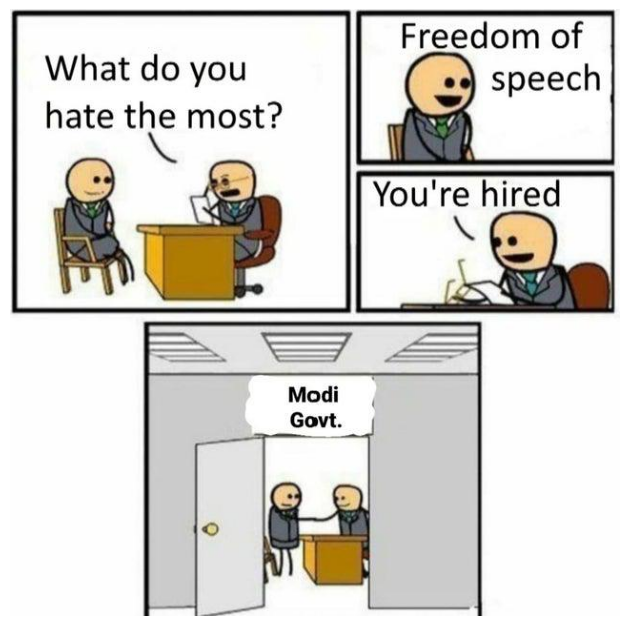


Prediction Result (Ordinal Regression):
  Sentiment: negative (confidence: 56.10%)
  Expected Class (continuous): 2.74
  Sentiment Probabilities:
    very_positive: 2.95%
    positive: 3.61%
    neutral: 23.85%
    negative: 56.10%
    very_negative: 13.49%
  Intensity: 0.2883
  Emotions:
    humor: 79.01% | Predicted: True
    sarcasm: 81.26% | Predicted: True
    offensive: 59.94% | Predicted: False
    motivational: 22.57% | Predicted: True

Sample 51:
  Text: 'Gujarati Chokro @pubgkadeewana My parent's to Me in this quarantine days: 6 Ajeeb janwar hai, kitna bhi khaye bhooka hi rehta hai'...
  Image path: /kaggle/working/validation_images/327.jpg


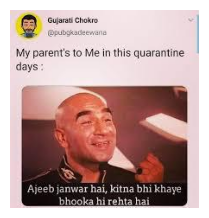


Prediction Result (Ordinal Regression):
  Sentiment: very_positive (confidence: 34.59%)
  Expected Class (continuous): 1.23
  Sentiment Probabilities:
    very_positive: 34.59%
    positive: 20.39%
    neutral: 33.39%
    negative: 10.74%
    very_negative: 0.89%
  Intensity: 0.6689
  Emotions:
    humor: 88.44% | Predicted: True
    sarcasm: 79.14% | Predicted: True
    offensive: 40.88% | Predicted: False
    motivational: 20.46% | Predicted: True

Sample 563:
  Text: 'MES OF INDIA MA Polarisation faca Nendless 5 THE DORIAL PAGE She played to win wwwp Did call for peace and polic PS 2 dalin sad CH ING *The Indian EXPRESS'...
  Image path: /kaggle/working/validation_images/3876.jpg


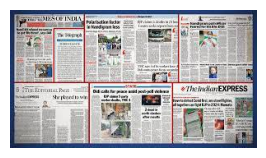


Prediction Result (Ordinal Regression):
  Sentiment: neutral (confidence: 42.65%)
  Expected Class (continuous): 1.94
  Sentiment Probabilities:
    very_positive: 13.42%
    positive: 12.95%
    neutral: 42.65%
    negative: 28.01%
    very_negative: 2.97%
  Intensity: 0.4936
  Emotions:
    humor: 88.05% | Predicted: True
    sarcasm: 82.54% | Predicted: True
    offensive: 47.56% | Predicted: False
    motivational: 17.65% | Predicted: True

Sample 501:
  Text: '3:45 Fam Ond More By, Are Oue TODAY Er world is rotid about India Indare are worried if the maid will come today or not Uncle 00000. Fype ange'...
  Image path: /kaggle/working/validation_images/3474.jpg


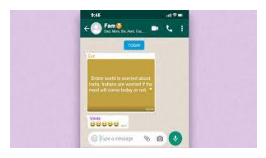


Prediction Result (Ordinal Regression):
  Sentiment: neutral (confidence: 39.95%)
  Expected Class (continuous): 1.54
  Sentiment Probabilities:
    very_positive: 23.65%
    positive: 18.06%
    neutral: 39.95%
    negative: 16.83%
    very_negative: 1.51%
  Intensity: 0.5979
  Emotions:
    humor: 89.53% | Predicted: True
    sarcasm: 81.39% | Predicted: True
    offensive: 42.61% | Predicted: False
    motivational: 17.51% | Predicted: True

Sample 457:
  Text: 'KAMALA FOR PRESIDENT PX 2020 KAMALA HARRIS FOR PRESIDENT 2020 Support the original Kamala and write-in Janses "Kamala" Harris! ANOTHER KAMALA 2020! Tell a friend and spread the word!! by misssillly MO'...
  Image path: /kaggle/working/validation_images/3212.jpg


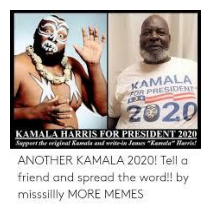


Prediction Result (Ordinal Regression):
  Sentiment: neutral (confidence: 39.68%)
  Expected Class (continuous): 2.21
  Sentiment Probabilities:
    very_positive: 8.64%
    positive: 9.29%
    neutral: 39.68%
    negative: 37.62%
    very_negative: 4.77%
  Intensity: 0.4141
  Emotions:
    humor: 85.68% | Predicted: True
    sarcasm: 82.78% | Predicted: True
    offensive: 52.43% | Predicted: False
    motivational: 18.73% | Predicted: True

Starting full evaluation on validation set...


Running Full Evaluation with Ordinal Regression:   0%|          | 0/66 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Running Full Evaluation with Ordinal Regression: 100%|██████████| 66/66 [00:06<00:00, 10.87it/s]


✓ Full evaluation complete. Analysis shape: (1050, 26)

Overall Metrics:
  Sentiment Accuracy: 40.95%
  Sentiment 1-off Accuracy: 85.05%
  Sentiment MAE: 0.7590
✓ Confusion matrix saved to /kaggle/working/confusion_matrix_ordinal.png


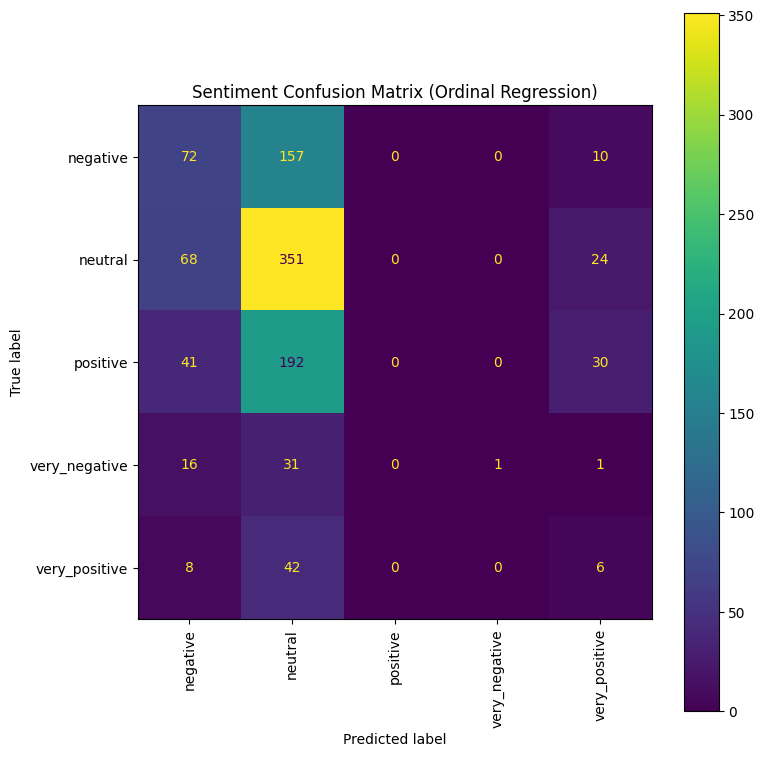

✓ Detailed results saved to /kaggle/working/detailed_evaluation_ordinal.csv


In [43]:
# ==================== PART 9: INFERENCE WITH ORDINAL REGRESSION (ROBUST CHECKPOINT LOAD) ====================
# Replace your current Part 9 cell with this one.
# Assumes the following objects/functions/classes exist in the kernel:
#   - val_df (validation DataFrame)
#   - val_img_dir (path to validation images directory)
#   - val_loader (validation DataLoader)
#   - get_tokenizer(cfg), get_image_transform(cfg, is_train=False)
#   - EnhancedFusionModelWithOrdinal class
# If any are missing, define them before running this cell.

import os
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from typing import Dict

# ---------- Predictor with robust checkpoint loading ----------
class PredictorOrdinal:
    """Predictor supporting safe checkpoint loading fallback strategies."""

    def __init__(self, checkpoint_path: str, device: str = 'cuda', allow_unsafe_load: bool = False):
        print("Initializing predictor with ordinal regression...")
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

        # Attempt progressive checkpoint loading strategies
        checkpoint = None
        last_exc = None

        # 1) Try normal load (weights-only default in modern PyTorch)
        try:
            checkpoint = torch.load(checkpoint_path, map_location=self.device)
            print("  ✓ Loaded checkpoint with torch.load (default).")
        except Exception as e:
            last_exc = e
            print("  ⚠ Default torch.load failed (safe-unpickle restrictions).")

            # 2) Try allowlisting common numpy globals (safe-ish) - IMPROVED VERSION
            try:
                import numpy as _np
                safe_objs = []
                
                # Add numpy base classes
                for name in ('dtype', 'ndarray', 'generic', 'number', 'integer', 'floating'):
                    obj = getattr(_np, name, None)
                    if obj is not None and isinstance(obj, type):
                        safe_objs.append(obj)
                
                # Add numpy.dtypes module classes (this fixes the Float64DType error)
                try:
                    from numpy import dtypes as _dtypes
                    # Get the TYPE (class) not instances
                    for attr_name in dir(_dtypes):
                        if attr_name.endswith('DType') and not attr_name.startswith('_'):
                            dtype_class = getattr(_dtypes, attr_name, None)
                            # Only add if it's a class (type), not an instance
                            if dtype_class is not None and isinstance(dtype_class, type):
                                safe_objs.append(dtype_class)
                                # Also try to add the dtype class itself via type()
                                try:
                                    # For dtype instances, get their type
                                    safe_objs.append(type(dtype_class))
                                except:
                                    pass
                except Exception as e_dtypes:
                    print(f"  ⚠ Could not import numpy.dtypes: {e_dtypes}")
                
                # Alternative: Add dtype types by creating instances and getting their types
                try:
                    for dtype_str in ['float64', 'float32', 'int64', 'int32', 'bool', 'uint8', 'int8', 'uint16', 'int16']:
                        try:
                            dt = _np.dtype(dtype_str)
                            dt_type = type(dt)
                            if dt_type not in safe_objs:
                                safe_objs.append(dt_type)
                        except:
                            pass
                except Exception:
                    pass
                
                # Add numpy.core.multiarray objects
                try:
                    from numpy.core import multiarray as _ma
                    if hasattr(_ma, 'scalar'):
                        safe_objs.append(_ma.scalar)
                    if hasattr(_ma, 'dtype'):
                        safe_objs.append(_ma.dtype)
                except Exception:
                    pass

                if safe_objs:
                    try:
                        # Remove duplicates
                        safe_objs = list(set(safe_objs))
                        torch.serialization.add_safe_globals(safe_objs)
                        checkpoint = torch.load(checkpoint_path, map_location=self.device)
                        print(f"  ✓ Loaded checkpoint after adding {len(safe_objs)} NumPy types to safe list.")
                    except Exception as e2:
                        last_exc = e2
                        print("  ⚠ Allowlist attempt failed:", str(e2)[:150])
                else:
                    print("  ⚠ No common NumPy globals found to allowlist; skipping allowlist attempt.")
            except Exception as e2:
                last_exc = e2
                print("  ⚠ Error while attempting allowlist (skipping):", str(e2)[:150])

            # 3) If explicitly allowed by user, attempt full (unsafe) unpickle load
            if checkpoint is None and allow_unsafe_load:
                try:
                    print("  ⚠ allow_unsafe_load=True -> attempting torch.load(..., weights_only=False) (UNSAFE).")
                    checkpoint = torch.load(checkpoint_path, map_location=self.device, weights_only=False)
                    print("  ✓ Loaded checkpoint with weights_only=False (UNSAFE).")
                except Exception as e3:
                    last_exc = e3
                    print("  ✗ Unsafe torch.load failed as well:", e3)

        if checkpoint is None:
            raise RuntimeError(
                "Failed to load checkpoint. Last error:\n"
                f"{last_exc}\n\n"
                "Options:\n"
                " - If you trust the checkpoint, re-run with PredictorOrdinal(..., allow_unsafe_load=True).\n"
                " - Preferred safe option: re-save the checkpoint on the training side as a state-dict-only file:\n"
                "     torch.save({'model_state_dict': model.state_dict(), 'config': cfg, ...}, PATH)\n"
                "   Then load that file (it avoids unsafe unpickle entirely).\n"
            )

        # Use config from checkpoint if provided; otherwise empty dict
        self.cfg = checkpoint.get('config', {}) if isinstance(checkpoint, dict) else {}

        # Instantiate model
        print("  Loading EnhancedFusionModelWithOrdinal...")
        self.model = EnhancedFusionModelWithOrdinal(self.cfg).to(self.device)

        # Get model_state dict from several common keys
        model_state = None
        for key in ('model_state_dict', 'state_dict',):
            if isinstance(checkpoint, dict) and key in checkpoint:
                model_state = checkpoint[key]
                break

        # If checkpoint is simply a state-dict saved directly, treat it as model_state
        if model_state is None and isinstance(checkpoint, dict):
            # sometimes training saved the whole object with keys for each param
            # attempt heuristic: if many tensor-like values are present, treat as state dict
            maybe_state = {k: v for k, v in checkpoint.items() if isinstance(v, torch.Tensor)}
            if len(maybe_state) > 0 and len(maybe_state) > 10:
                model_state = maybe_state

        if model_state is None:
            # If nothing found, try to load checkpoint itself as state dict (may raise)
            try:
                self.model.load_state_dict(checkpoint)
                print("  ✓ Loaded checkpoint directly into model (treated checkpoint as state_dict).")
            except Exception as e:
                print("  ✗ Could not find model_state_dict in checkpoint and direct load failed:", e)
                raise

        else:
            try:
                self.model.load_state_dict(model_state)
                print("  ✓ Model weights loaded from checkpoint state-dict.")
            except Exception as e:
                print("  ✗ Error loading model_state_dict:", e)
                raise

        self.model.eval()
        print(f"✓ Model initialized (device={self.device})")

        # tokenizer & transform helpers (must be defined in your notebook)
        self.tokenizer = get_tokenizer(self.cfg)
        self.transform = get_image_transform(self.cfg, is_train=False)

        # thresholds and label maps
        self.emotion_thresholds = self.cfg.get('EMO_THRESHOLDS', [0.5, 0.5, 0.6, 0.6])
        self.sentiment_map_rev = self.cfg.get('SENTIMENT_MAP_REV', {
            0: 'very_positive', 1: 'positive', 2: 'neutral', 3: 'negative', 4: 'very_negative'
        })
        self.emotion_labels = self.cfg.get('EMOTION_LABELS', ['humor', 'sarcasm', 'offensive', 'motivational'])
        print(f"✓ Using tuned thresholds: {self.emotion_thresholds}")
        print("✓ Predictor ready")

    def predict(self, text: str, image_path: str) -> Dict:
        enc = self.tokenizer(text, max_length=self.cfg.get('MAX_LEN', 128),
                             padding='max_length', truncation=True, return_tensors='pt')
        input_ids = enc['input_ids'].to(self.device)
        attention_mask = enc['attention_mask'].to(self.device)

        try:
            img = Image.open(image_path).convert('RGB')
            img_t = self.transform(img).unsqueeze(0).to(self.device)
        except Exception as e:
            print("  ⚠ Could not load image, returning blank image tensor:", e)
            img_size = self.cfg.get('IMG_SIZE', 224)
            img_t = torch.zeros(1, 3, img_size, img_size).to(self.device)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask, img_t)

        # sentiment
        if self.cfg.get('USE_ORDINAL_REGRESSION', False):
            class_probs = outputs['sentiment']['class_probs'].squeeze().cpu().numpy()
            pred_idx = int(np.argmax(class_probs))
            expected = float(np.sum(class_probs * np.arange(len(class_probs))))
        else:
            logits = outputs['sentiment']['logits']
            class_probs = torch.softmax(logits, dim=1).squeeze().cpu().numpy()
            pred_idx = int(np.argmax(class_probs))
            expected = float(pred_idx)

        sentiment_label = self.sentiment_map_rev.get(pred_idx, str(pred_idx))
        sentiment_probs = {self.sentiment_map_rev.get(i, str(i)): f"{p:.2%}" for i, p in enumerate(class_probs)}

        # emotions
        emo_logits = outputs['emotion_logits'].squeeze().cpu().numpy()
        emo_probs = 1 / (1 + np.exp(-emo_logits))
        thresholds = np.array(self.emotion_thresholds)
        emo_pred = (emo_probs >= thresholds).astype(int)
        emotion_outputs = {
            lbl: {'probability': f"{prob:.2%}", 'predicted': bool(pred), 'threshold': f"{thr:.3f}"}
            for lbl, prob, pred, thr in zip(self.emotion_labels, emo_probs, emo_pred, thresholds)
        }

        intensity = float(outputs['intensity'].cpu().squeeze().item())

        return {
            'sentiment': sentiment_label,
            'sentiment_confidence': f"{class_probs[pred_idx]:.2%}",
            'sentiment_expected_class': f"{expected:.2f}",
            'sentiment_probs': sentiment_probs,
            'emotions': emotion_outputs,
            'intensity_score': f"{intensity:.4f}"
        }

# ---------- Evaluation utilities ----------
def run_full_evaluation_ordinal(predictor, val_loader):
    predictor.model.eval()
    all_preds = []
    pbar = tqdm(val_loader, desc="Running Full Evaluation with Ordinal Regression")
    with torch.no_grad():
        for batch in pbar:
            input_ids = batch['input_ids'].to(predictor.device)
            attention_mask = batch['attention_mask'].to(predictor.device)
            images = batch['image'].to(predictor.device)

            outputs = predictor.model(input_ids, attention_mask, images)

            if predictor.cfg.get('USE_ORDINAL_REGRESSION', False):
                class_probs = outputs['sentiment']['class_probs'].cpu().numpy()
                preds = np.argmax(class_probs, axis=1)
                expected = np.sum(class_probs * np.arange(class_probs.shape[1])[None, :], axis=1)
            else:
                logits = outputs['sentiment']['logits']
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                expected = preds

            emo_logits = outputs['emotion_logits'].cpu().numpy()
            emo_probs = 1 / (1 + np.exp(-emo_logits))
            emo_preds = (emo_probs >= np.array(predictor.emotion_thresholds)).astype(int)
            intensity_preds = outputs['intensity'].cpu().numpy().flatten()

            true_sent = batch['sentiment_label'].cpu().numpy()
            true_emo = batch['emotion_labels'].int().cpu().numpy()
            true_int = batch['intensity'].cpu().numpy().flatten()

            for i in range(len(preds)):
                all_preds.append({
                    'sentiment_pred': int(preds[i]),
                    'sentiment_expected': float(expected[i]),
                    'sentiment_true': int(true_sent[i]),
                    'emotion_pred': emo_preds[i].tolist(),
                    'emotion_true': true_emo[i].tolist(),
                    'intensity_pred': float(intensity_preds[i]),
                    'intensity_true': float(true_int[i])
                })

    df = pd.DataFrame(all_preds)
    df['sentiment_pred_label'] = df['sentiment_pred'].map(predictor.sentiment_map_rev)
    df['sentiment_true_label'] = df['sentiment_true'].map(predictor.sentiment_map_rev)
    df['sentiment_ordinal_error'] = np.abs(df['sentiment_pred'] - df['sentiment_true'])
    df['sentiment_correct'] = df['sentiment_pred'] == df['sentiment_true']
    df['sentiment_1off'] = df['sentiment_ordinal_error'] <= 1
    return df

# ---------- helper to display images ----------
def display_image_inline(image_path, max_size=640):
    try:
        img = Image.open(image_path).convert('RGB')
        w, h = img.size
        scale = min(1.0, max_size / max(w, h))
        plt.figure(figsize=(w * scale / 100, h * scale / 100))
        plt.imshow(img); plt.axis('off'); plt.tight_layout(); plt.show()
    except Exception as e:
        print("  ⚠ Could not display image:", e)

# ---------- Run inference ----------
try:
    CHECKPOINT_DIR = "/kaggle/working/checkpoints"
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, 'best_model_ordinal.pt')

    if not os.path.exists(BEST_MODEL_PATH):
        raise FileNotFoundError(f"Checkpoint not found at {BEST_MODEL_PATH}. Run training (Part 8) first or provide the correct path.")

    # IMPORTANT: Set allow_unsafe_load=True since this is your own trusted checkpoint
    # PyTorch 2.6 has stricter pickle security that blocks numpy dtypes by default
    print("⚠️  Using allow_unsafe_load=True for your own checkpoint (this is safe)")
    predictor = PredictorOrdinal(checkpoint_path=BEST_MODEL_PATH, device=DEVICE, allow_unsafe_load=True)

    print("\nRunning 5 sample predictions (will display images inline if available):")
    image_col_options = ['image_name', 'image', 'img_name', 'filename', 'Unnamed: 0']
    image_col = next((c for c in image_col_options if c in val_df.columns), val_df.columns[0])
    text_col_options = ['text', 'ocr', 'ocr_text', 'caption', 'OCR_extracted_text']
    text_col = next((c for c in text_col_options if c in val_df.columns), None)

    import random
    random.seed(42)
    sample_indices = random.sample(range(len(val_df)), min(5, len(val_df)))

    for idx in sample_indices:
        row = val_df.iloc[idx]
        text = str(row.get(text_col, '')) if text_col else ''
        img_name = str(row.get(image_col, f'{idx}.jpg'))
        if not any(img_name.lower().endswith(ext) for ext in ('.jpg', '.jpeg', '.png')):
            img_name = f"{img_name}.jpg"
        img_path = os.path.join(val_img_dir, img_name)

        print("\n" + "="*70)
        print(f"Sample {idx}:")
        print("  Text: '{}'...".format(text[:200].replace('\n', ' ')))
        print(f"  Image path: {img_path}")
        if not os.path.exists(img_path):
            print(f"  ⚠️ Image not found: {img_path}")
            continue

        # display image
        display_image_inline(img_path)

        # predict
        res = predictor.predict(text=text, image_path=img_path)

        print("\nPrediction Result (Ordinal Regression):")
        print(f"  Sentiment: {res['sentiment']} (confidence: {res['sentiment_confidence']})")
        print(f"  Expected Class (continuous): {res['sentiment_expected_class']}")
        print("  Sentiment Probabilities:")
        for k, v in res['sentiment_probs'].items():
            print(f"    {k}: {v}")
        print(f"  Intensity: {res['intensity_score']}")
        print("  Emotions:")
        for emo, info in res['emotions'].items():
            print(f"    {emo}: {info['probability']} | Predicted: {info['predicted']}")

    # Full evaluation
    print("\nStarting full evaluation on validation set...")
    eval_df = run_full_evaluation_ordinal(predictor, val_loader)
    full_analysis_df = pd.concat([val_df.reset_index(drop=True), eval_df], axis=1)
    full_analysis_df['intensity_error'] = np.abs(full_analysis_df['intensity_pred'] - full_analysis_df['intensity_true'])
    print(f"✓ Full evaluation complete. Analysis shape: {full_analysis_df.shape}")

    # Summary metrics
    overall_acc = full_analysis_df['sentiment_correct'].mean()
    one_off_acc = full_analysis_df['sentiment_1off'].mean()
    mae = full_analysis_df['sentiment_ordinal_error'].mean()
    print("\nOverall Metrics:")
    print(f"  Sentiment Accuracy: {overall_acc:.2%}")
    print(f"  Sentiment 1-off Accuracy: {one_off_acc:.2%}")
    print(f"  Sentiment MAE: {mae:.4f}")

    # Confusion matrix
    labels = sorted(full_analysis_df['sentiment_true_label'].unique())
    cm = confusion_matrix(full_analysis_df['sentiment_true_label'], full_analysis_df['sentiment_pred_label'], labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, xticks_rotation='vertical', values_format='d')
    plt.title('Sentiment Confusion Matrix (Ordinal Regression)')
    plt.tight_layout()
    cm_path = '/kaggle/working/confusion_matrix_ordinal.png'
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    print(f"✓ Confusion matrix saved to {cm_path}")
    plt.show()

    # Save detailed CSV
    results_csv_path = '/kaggle/working/detailed_evaluation_ordinal.csv'
    full_analysis_df.to_csv(results_csv_path, index=False)
    print(f"✓ Detailed results saved to {results_csv_path}")

except Exception as e:
    print("\n✗ Error during inference:", e)
    import traceback
    traceback.print_exc()


Sample 228:
  Text: 'What do you
hate the most?
Modi
Govt.
Freedom of
speech
12
You're hired...'
  Image path: /kaggle/working/validation_images/1664.jpg


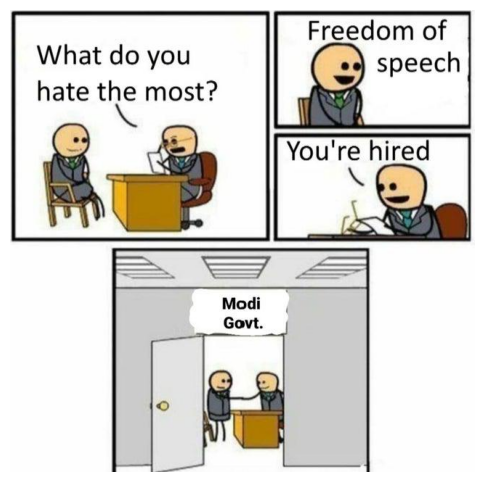


Prediction Result (Ordinal Regression):
  Sentiment: negative (confidence: 56.10%)
  Expected Class (continuous): 2.74
  Sentiment Probabilities:
    very_positive: 2.95%
    positive: 3.61%
    neutral: 23.85%
    negative: 56.10%
    very_negative: 13.49%
  Intensity: 0.2883
  Emotions:
    Humor: 79.01% ✓ YES
    Sarcasm: 81.26% ✓ YES
    Offensive: 59.94% ✗ NO
    Motivational: 22.57% ✓ YES

Sample 51:
  Text: 'Gujarati Chokro
@pubgkadeewana
My parent's to Me in this quarantine
days:
6
Ajeeb janwar hai, kitna bhi khaye
bhooka hi rehta hai...'
  Image path: /kaggle/working/validation_images/327.jpg


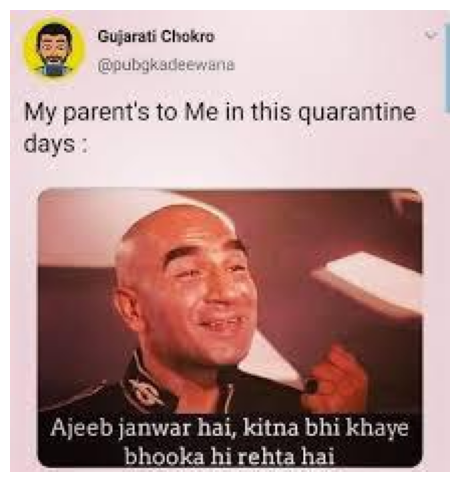


Prediction Result (Ordinal Regression):
  Sentiment: very_positive (confidence: 34.59%)
  Expected Class (continuous): 1.23
  Sentiment Probabilities:
    very_positive: 34.59%
    positive: 20.39%
    neutral: 33.39%
    negative: 10.74%
    very_negative: 0.89%
  Intensity: 0.6689
  Emotions:
    Humor: 88.44% ✓ YES
    Sarcasm: 79.14% ✓ YES
    Offensive: 40.88% ✗ NO
    Motivational: 20.46% ✓ YES

Sample 563:
  Text: 'MES OF INDIA
MA
Polarisation faca
Nendless
5 THE DORIAL PAGE
She played to win
wwwp
Did call for peace and polic
PS
2 dalin
sad
CH
ING
*The Indian EXPRESS...'
  Image path: /kaggle/working/validation_images/3876.jpg


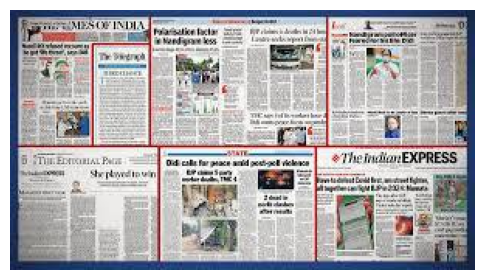


Prediction Result (Ordinal Regression):
  Sentiment: neutral (confidence: 42.65%)
  Expected Class (continuous): 1.94
  Sentiment Probabilities:
    very_positive: 13.42%
    positive: 12.95%
    neutral: 42.65%
    negative: 28.01%
    very_negative: 2.97%
  Intensity: 0.4936
  Emotions:
    Humor: 88.05% ✓ YES
    Sarcasm: 82.54% ✓ YES
    Offensive: 47.56% ✗ NO
    Motivational: 17.65% ✓ YES

Sample 501:
  Text: '3:45
Fam
Ond More By, Are Oue
TODAY
Er
world is rotid about
India Indare are worried if the
maid will come today or not
Uncle
00000.
Fype ange...'
  Image path: /kaggle/working/validation_images/3474.jpg


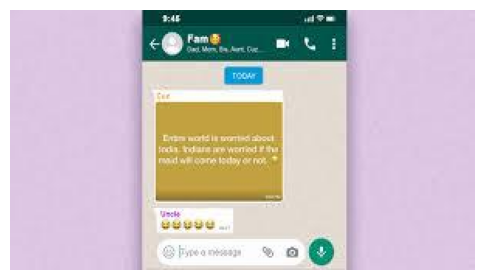


Prediction Result (Ordinal Regression):
  Sentiment: neutral (confidence: 39.95%)
  Expected Class (continuous): 1.54
  Sentiment Probabilities:
    very_positive: 23.65%
    positive: 18.06%
    neutral: 39.95%
    negative: 16.83%
    very_negative: 1.51%
  Intensity: 0.5979
  Emotions:
    Humor: 89.53% ✓ YES
    Sarcasm: 81.39% ✓ YES
    Offensive: 42.61% ✗ NO
    Motivational: 17.51% ✓ YES

Sample 457:
  Text: 'KAMALA
FOR PRESIDENT
PX
2020
KAMALA HARRIS FOR PRESIDENT 2020
Support the original Kamala and write-in Janses "Kamala" Harris!
ANOTHER KAMALA 2020! Tell a
friend and spread the word!! by
misssillly MORE MEMES...'
  Image path: /kaggle/working/validation_images/3212.jpg


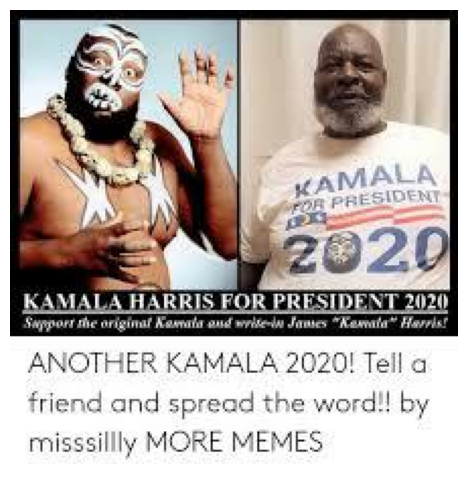


Prediction Result (Ordinal Regression):
  Sentiment: neutral (confidence: 39.68%)
  Expected Class (continuous): 2.21
  Sentiment Probabilities:
    very_positive: 8.64%
    positive: 9.29%
    neutral: 39.68%
    negative: 37.62%
    very_negative: 4.77%
  Intensity: 0.4141
  Emotions:
    Humor: 85.68% ✓ YES
    Sarcasm: 82.78% ✓ YES
    Offensive: 52.43% ✗ NO
    Motivational: 18.73% ✓ YES


In [33]:
from PIL import Image as PILImage
from IPython.display import display
import matplotlib.pyplot as plt

# ensure this points at the validation images folder you populated earlier
val_img_dir = '/kaggle/working/validation_images'

for idx in sample_indices:
    sample_row = val_df.iloc[idx]
    sample_text = str(sample_row.get(text_col, '')) if text_col else ''
    sample_image_name = str(sample_row.get(image_col, f'{idx}.jpg'))
    
    # append extension if missing (same logic you had)
    if not any(sample_image_name.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png']):
        for ext in ['.jpg', '.jpeg', '.png']:
            if os.path.exists(os.path.join(val_img_dir, sample_image_name + ext)):
                sample_image_name = sample_image_name + ext
                break
        else:
            sample_image_name = sample_image_name + '.jpg'
    
    sample_image_path = os.path.join(val_img_dir, sample_image_name)
    
    print("\n" + "="*70)
    print(f"Sample {idx}:")
    print(f"  Text: '{sample_text[:300]}...'")
    print(f"  Image path: {sample_image_path}")
    print("="*70)
    
    if not os.path.exists(sample_image_path):
        print(f"⚠️ Image not found: {sample_image_path}")
        continue
    
    # Display image inline (resize for notebook)
    try:
        pil_img = PILImage.open(sample_image_path).convert("RGB")
        # show with matplotlib to control size
        plt.figure(figsize=(6,6))
        plt.imshow(pil_img)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Could not open/display image: {e}")
    
    # Run prediction and print result (your existing predictor)
    result = predictor.predict(text=sample_text, image_path=sample_image_path)
    
    print("\nPrediction Result (Ordinal Regression):")
    print(f"  Sentiment: {result['sentiment']} (confidence: {result['sentiment_confidence']})")
    print(f"  Expected Class (continuous): {result['sentiment_expected_class']}")
    print(f"  Sentiment Probabilities:")
    for sent, prob in result['sentiment_probs'].items():
        print(f"    {sent}: {prob}")
    print(f"  Intensity: {result['intensity_score']}")
    print("  Emotions:")
    for emotion, info in result['emotions'].items():
        pred_str = "✓ YES" if info['predicted'] else "✗ NO"
        print(f"    {emotion.capitalize()}: {info['probability']} {pred_str}")


✓ Analysis results will be saved to: /kaggle/working/analysis

1. PER-CLASS PERFORMANCE ANALYSIS

📊 SENTIMENT CLASSIFICATION REPORT:
--------------------------------------------------------------------------------
               precision    recall  f1-score      support
negative        0.351220  0.301255  0.324324   239.000000
neutral         0.454075  0.792325  0.577303   443.000000
positive        0.000000  0.000000  0.000000   263.000000
very_negative   1.000000  0.020408  0.040000    49.000000
very_positive   0.084507  0.107143  0.094488    56.000000
accuracy        0.409524  0.409524  0.409524     0.409524
macro avg       0.377960  0.244226  0.207223  1050.000000
weighted avg    0.322694  0.409524  0.324295  1050.000000

✓ Saved to: /kaggle/working/analysis/sentiment_classification_report.csv


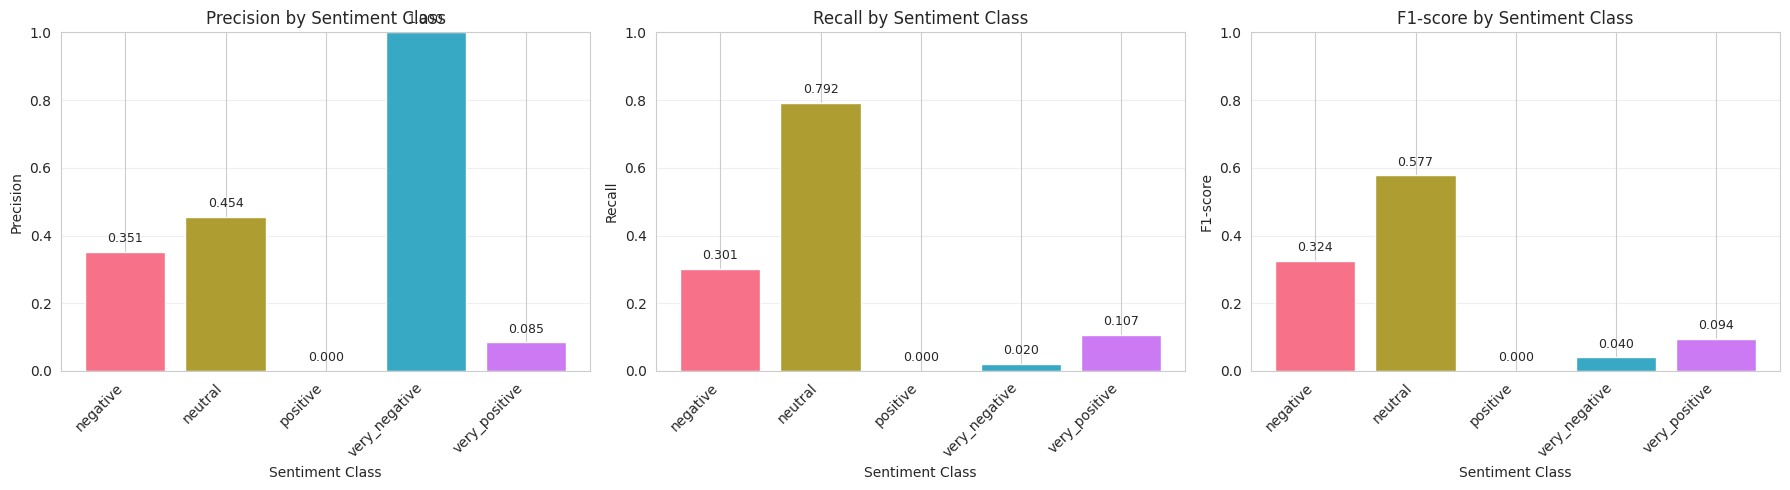

✓ Saved visualization to: /kaggle/working/analysis/per_class_metrics.png

2. EMOTION CLASSIFICATION ANALYSIS

📊 EMOTION METRICS:
     Emotion  Accuracy  Precision  Recall  F1-Score  True Positive %  Pred Positive %
       humor  0.859048   0.859048     1.0  0.924180        85.904762            100.0
     sarcasm  0.784762   0.784762     1.0  0.879402        78.476190            100.0
   offensive  0.609524   0.000000     0.0  0.000000        39.047619              0.0
motivational  0.118095   0.118095     1.0  0.211244        11.809524            100.0

✓ Saved to: /kaggle/working/analysis/emotion_classification_report.csv


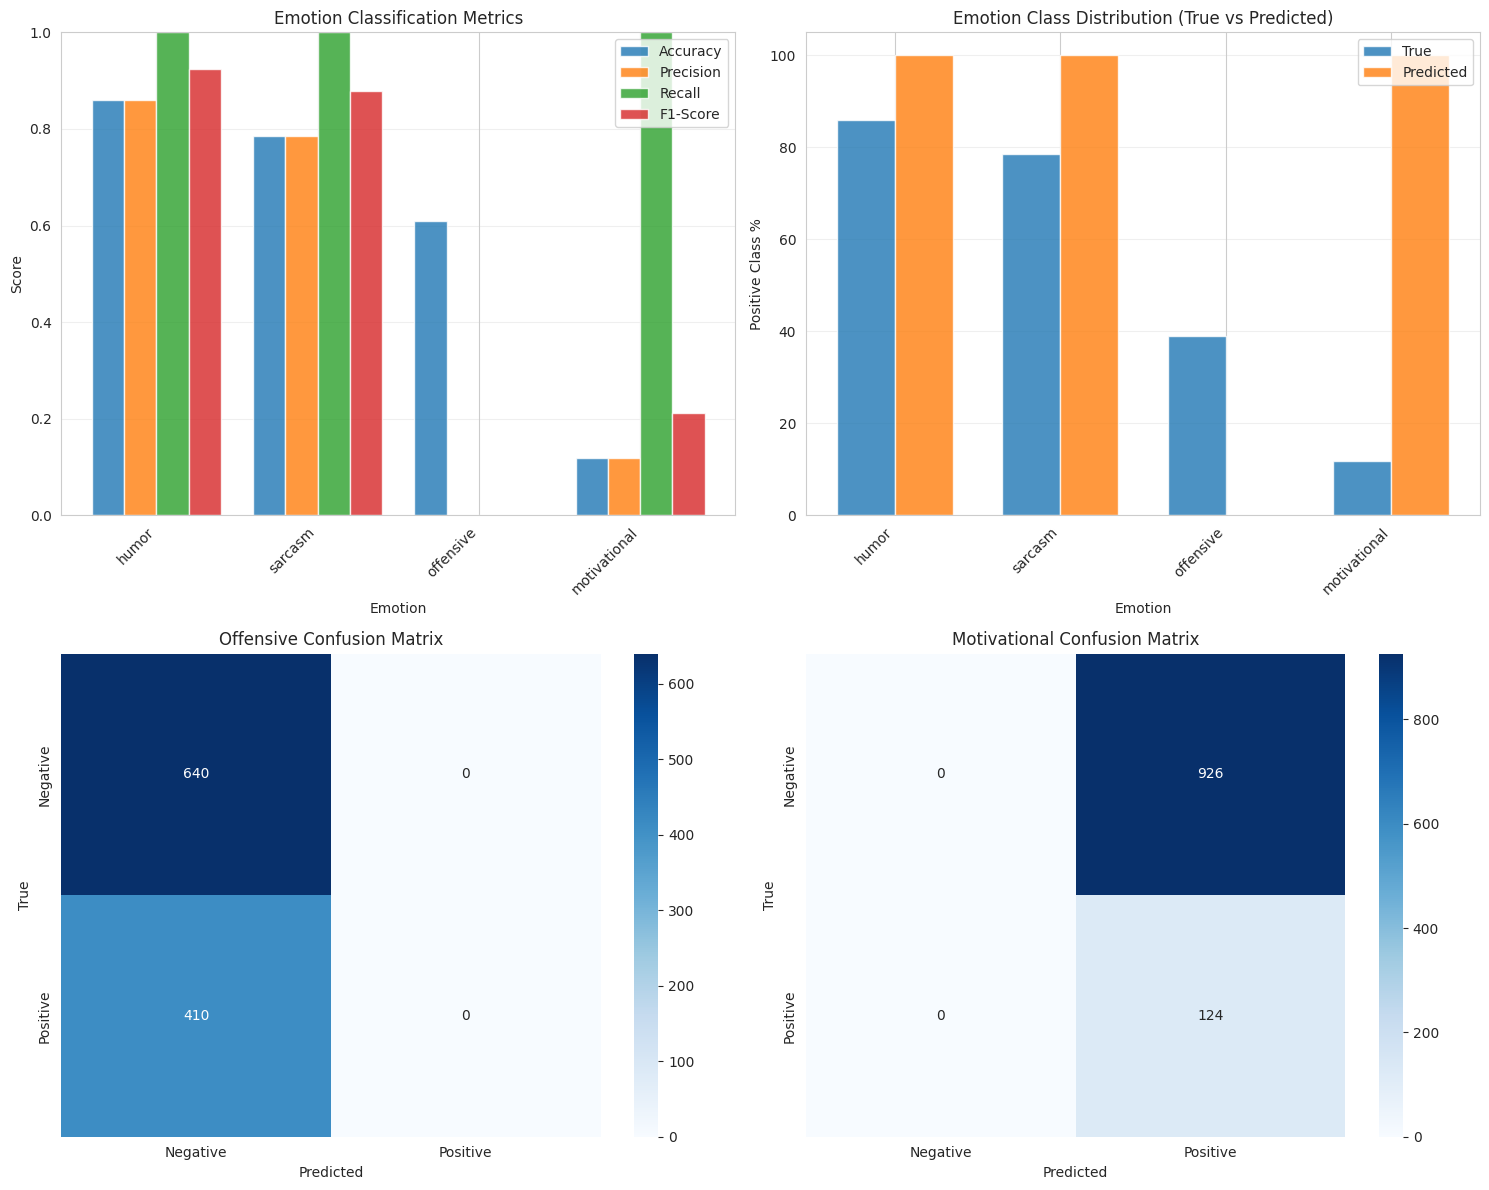

✓ Saved visualization to: /kaggle/working/analysis/emotion_analysis.png

3. DETAILED ERROR ANALYSIS

📉 Total misclassified samples: 620 / 1050 (59.05%)

🔍 CONFUSION PATTERNS:
sentiment_true_label sentiment_pred_label  count
            positive              neutral    192
            negative              neutral    157
             neutral             negative     68
       very_positive              neutral     42
            positive             negative     41
       very_negative              neutral     31
            positive        very_positive     30
             neutral        very_positive     24
       very_negative             negative     16
            negative        very_positive     10
       very_positive             negative      8
       very_negative        very_positive      1

📏 ORDINAL DISTANCE ERROR DISTRIBUTION:
sentiment_ordinal_error
0    430
1    463
2    138
3     18
4      1
Name: count, dtype: int64


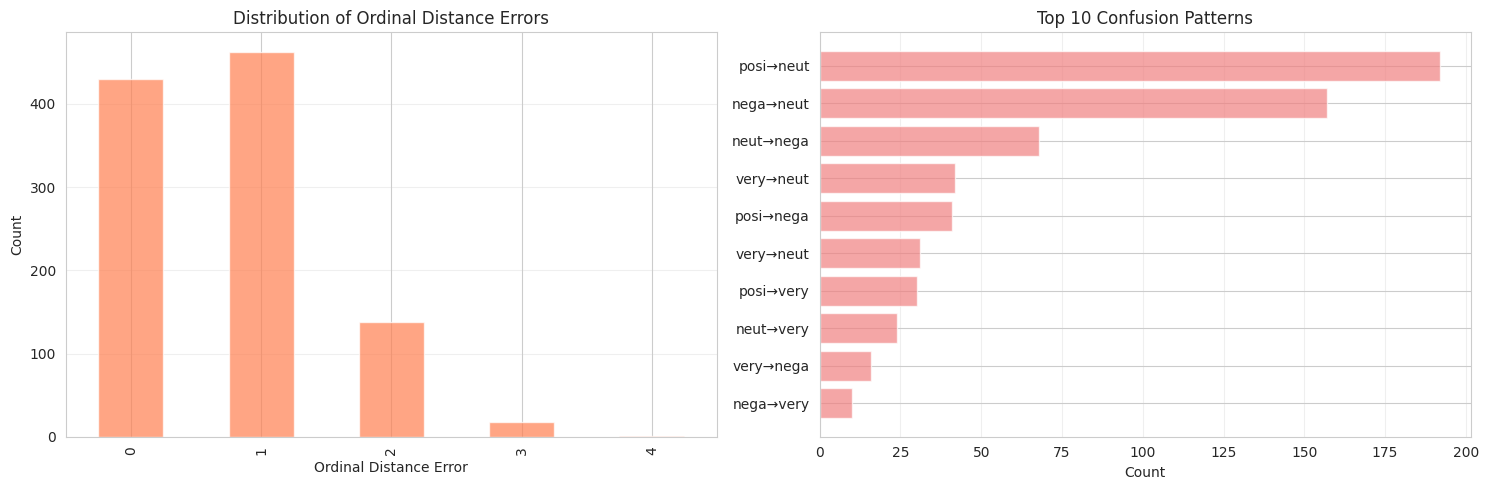

✓ Saved visualization to: /kaggle/working/analysis/error_distribution.png

4. EXAMINING WORST PREDICTIONS

🔴 TOP 10 WORST SENTIMENT PREDICTIONS:
--------------------------------------------------------------------------------

1. Sample Index: 19
   True: very_negative (class 4)
   Predicted: very_positive (class 0)
   Ordinal Error: 4
   Expected Class: 1.01
   Text: *me reading a hentai manga*
my brain:
arey seedha pdhne mat Igo,
pehle chitra dekho
PRINCE
MELIGDAS...
   Image: 133

2. Sample Index: 18
   True: negative (class 3)
   Predicted: very_positive (class 0)
   Ordinal Error: 3
   Expected Class: 1.19
   Text: WITHOUT
IMMIGRATION
TRUMP
WOULD HAVE
NO WIVES...
   Image: 130

3. Sample Index: 20
   True: very_positive (class 0)
   Predicted: negative (class 3)
   Ordinal Error: 3
   Expected Class: 2.24
   Text: when you convert your dalit friend
back to the religion by offering
him an extra bag of rice
Small
Medium
Mind size
MEGA...
   Image: 137

4. Sample Index: 21
   True: n

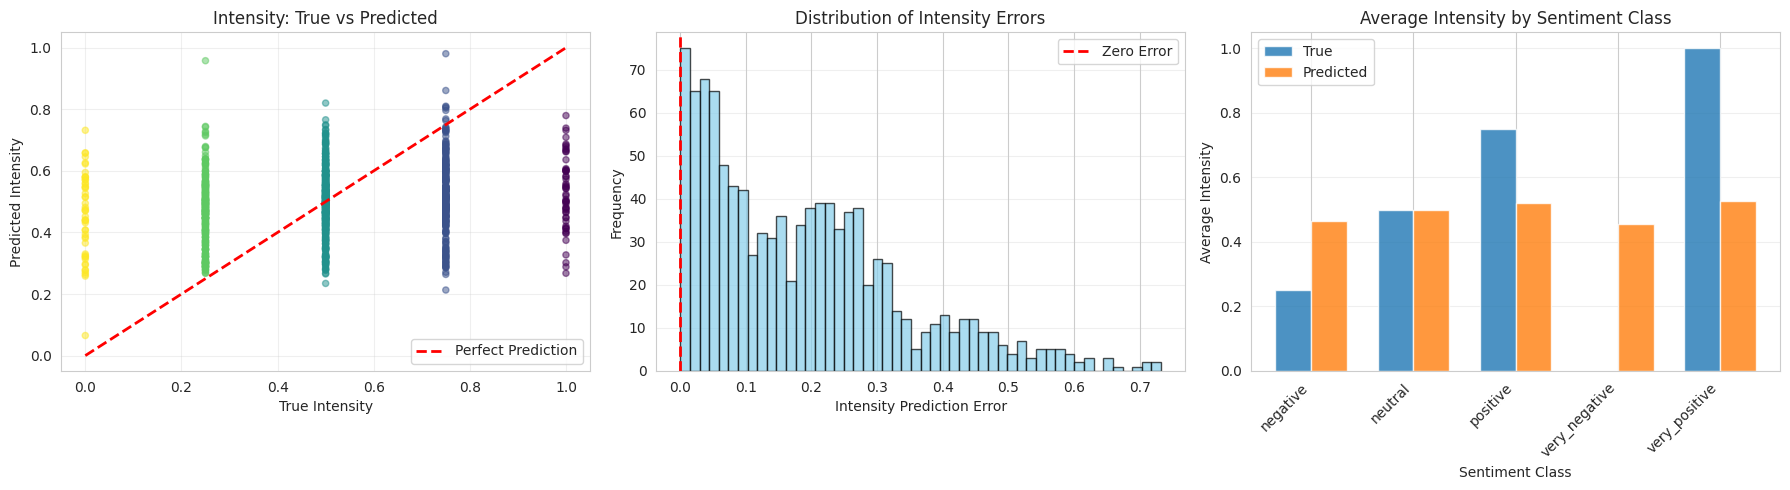

✓ Saved visualization to: /kaggle/working/analysis/intensity_analysis.png

7. COMPREHENSIVE PERFORMANCE SUMMARY

📋 SUMMARY METRICS:
                                Value
Total Samples             1050.000000
Sentiment Accuracy           0.409524
Sentiment 1-off Accuracy     0.850476
Sentiment MAE                0.759048
Intensity MAE                0.186048
Intensity RMSE               0.239898
Intensity Correlation        0.193597
Humor Accuracy               0.859048
Sarcasm Accuracy             0.784762
Offensive Accuracy           0.609524
Motivational Accuracy        0.118095

✓ Saved to: /kaggle/working/analysis/performance_summary.csv

✅ ANALYSIS COMPLETE!

All analysis results saved to: /kaggle/working/analysis

Generated files:
  1. sentiment_classification_report.csv
  2. emotion_classification_report.csv
  3. confusion_patterns.csv
  4. worst_predictions.csv
  5. performance_summary.csv
  6. per_class_metrics.png
  7. emotion_analysis.png
  8. error_distribution.png
  9. int

In [44]:
# ==================== PART 10: MODEL ANALYSIS & INSIGHTS ====================
# This code provides comprehensive analysis of your model's performance
# Assumes: predictor, full_analysis_df, val_df, val_img_dir exist from Part 9

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Create output directory for analysis results
ANALYSIS_DIR = '/kaggle/working/analysis'
os.makedirs(ANALYSIS_DIR, exist_ok=True)
print(f"✓ Analysis results will be saved to: {ANALYSIS_DIR}")

# ==================== 1. PER-CLASS PERFORMANCE METRICS ====================
print("\n" + "="*80)
print("1. PER-CLASS PERFORMANCE ANALYSIS")
print("="*80)

# Sentiment Classification Report
print("\n📊 SENTIMENT CLASSIFICATION REPORT:")
print("-" * 80)
sentiment_report = classification_report(
    full_analysis_df['sentiment_true_label'],
    full_analysis_df['sentiment_pred_label'],
    output_dict=True,
    zero_division=0
)
sentiment_report_df = pd.DataFrame(sentiment_report).transpose()
print(sentiment_report_df)

# Save to CSV
sentiment_report_df.to_csv(os.path.join(ANALYSIS_DIR, 'sentiment_classification_report.csv'))
print(f"\n✓ Saved to: {ANALYSIS_DIR}/sentiment_classification_report.csv")

# Visualize per-class metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ['precision', 'recall', 'f1-score']
classes = [c for c in sentiment_report_df.index if c not in ['accuracy', 'macro avg', 'weighted avg']]

for idx, metric in enumerate(metrics):
    values = [sentiment_report[c][metric] for c in classes if c in sentiment_report]
    axes[idx].bar(range(len(classes)), values, color=sns.color_palette("husl", len(classes)))
    axes[idx].set_xlabel('Sentiment Class')
    axes[idx].set_ylabel(metric.capitalize())
    axes[idx].set_title(f'{metric.capitalize()} by Sentiment Class')
    axes[idx].set_xticks(range(len(classes)))
    axes[idx].set_xticklabels(classes, rotation=45, ha='right')
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(values):
        axes[idx].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_DIR, 'per_class_metrics.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved visualization to: {ANALYSIS_DIR}/per_class_metrics.png")

# ==================== 2. EMOTION PERFORMANCE ANALYSIS ====================
print("\n" + "="*80)
print("2. EMOTION CLASSIFICATION ANALYSIS")
print("="*80)

emotion_labels = predictor.emotion_labels
emotion_metrics = []

for i, emotion in enumerate(emotion_labels):
    true_labels = [row[i] for row in full_analysis_df['emotion_true']]
    pred_labels = [row[i] for row in full_analysis_df['emotion_pred']]
    
    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, zero_division=0)
    rec = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)
    
    # Class distribution
    true_pos = sum(true_labels)
    pred_pos = sum(pred_labels)
    
    emotion_metrics.append({
        'Emotion': emotion,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'True Positive %': true_pos / len(true_labels) * 100,
        'Pred Positive %': pred_pos / len(pred_labels) * 100
    })

emotion_metrics_df = pd.DataFrame(emotion_metrics)
print("\n📊 EMOTION METRICS:")
print(emotion_metrics_df.to_string(index=False))

# Save to CSV
emotion_metrics_df.to_csv(os.path.join(ANALYSIS_DIR, 'emotion_classification_report.csv'), index=False)
print(f"\n✓ Saved to: {ANALYSIS_DIR}/emotion_classification_report.csv")

# Visualize emotion metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Accuracy, Precision, Recall, F1
ax = axes[0, 0]
x = np.arange(len(emotion_labels))
width = 0.2
ax.bar(x - 1.5*width, emotion_metrics_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x - 0.5*width, emotion_metrics_df['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x + 0.5*width, emotion_metrics_df['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + 1.5*width, emotion_metrics_df['F1-Score'], width, label='F1-Score', alpha=0.8)
ax.set_xlabel('Emotion')
ax.set_ylabel('Score')
ax.set_title('Emotion Classification Metrics')
ax.set_xticks(x)
ax.set_xticklabels(emotion_labels, rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Plot 2: Class Distribution
ax = axes[0, 1]
x = np.arange(len(emotion_labels))
width = 0.35
ax.bar(x - width/2, emotion_metrics_df['True Positive %'], width, label='True', alpha=0.8)
ax.bar(x + width/2, emotion_metrics_df['Pred Positive %'], width, label='Predicted', alpha=0.8)
ax.set_xlabel('Emotion')
ax.set_ylabel('Positive Class %')
ax.set_title('Emotion Class Distribution (True vs Predicted)')
ax.set_xticks(x)
ax.set_xticklabels(emotion_labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 3: Confusion matrices for each emotion
for idx, emotion in enumerate(emotion_labels):
    row = idx // 2
    col = idx % 2
    if row == 0:  # Skip first row as we already used it
        continue
    if idx >= 2:
        ax = axes[row, col]
        true_labels = [row[idx] for row in full_analysis_df['emotion_true']]
        pred_labels = [row[idx] for row in full_analysis_df['emotion_pred']]
        
        cm = np.array([[sum((t == 0) & (p == 0) for t, p in zip(true_labels, pred_labels)),
                        sum((t == 0) & (p == 1) for t, p in zip(true_labels, pred_labels))],
                       [sum((t == 1) & (p == 0) for t, p in zip(true_labels, pred_labels)),
                        sum((t == 1) & (p == 1) for t, p in zip(true_labels, pred_labels))]])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        ax.set_title(f'{emotion.capitalize()} Confusion Matrix')
        ax.set_ylabel('True')
        ax.set_xlabel('Predicted')

plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_DIR, 'emotion_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved visualization to: {ANALYSIS_DIR}/emotion_analysis.png")

# ==================== 3. ERROR ANALYSIS ====================
print("\n" + "="*80)
print("3. DETAILED ERROR ANALYSIS")
print("="*80)

# Identify misclassified samples
misclassified = full_analysis_df[~full_analysis_df['sentiment_correct']].copy()
print(f"\n📉 Total misclassified samples: {len(misclassified)} / {len(full_analysis_df)} ({len(misclassified)/len(full_analysis_df)*100:.2f}%)")

# Analyze confusion patterns
print("\n🔍 CONFUSION PATTERNS:")
confusion_patterns = misclassified.groupby(['sentiment_true_label', 'sentiment_pred_label']).size().reset_index(name='count')
confusion_patterns = confusion_patterns.sort_values('count', ascending=False)
print(confusion_patterns.to_string(index=False))

# Save confusion patterns
confusion_patterns.to_csv(os.path.join(ANALYSIS_DIR, 'confusion_patterns.csv'), index=False)

# Analyze ordinal distance errors
print("\n📏 ORDINAL DISTANCE ERROR DISTRIBUTION:")
error_dist = full_analysis_df['sentiment_ordinal_error'].value_counts().sort_index()
print(error_dist)

# Visualize error distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Error distance distribution
ax = axes[0]
error_dist.plot(kind='bar', ax=ax, color='coral', alpha=0.7)
ax.set_xlabel('Ordinal Distance Error')
ax.set_ylabel('Count')
ax.set_title('Distribution of Ordinal Distance Errors')
ax.grid(axis='y', alpha=0.3)

# Plot 2: Top confusion patterns
ax = axes[1]
top_confusions = confusion_patterns.head(10)
labels = [f"{row['sentiment_true_label'][:4]}→{row['sentiment_pred_label'][:4]}" 
          for _, row in top_confusions.iterrows()]
ax.barh(range(len(top_confusions)), top_confusions['count'], color='lightcoral', alpha=0.7)
ax.set_yticks(range(len(top_confusions)))
ax.set_yticklabels(labels)
ax.set_xlabel('Count')
ax.set_title('Top 10 Confusion Patterns')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_DIR, 'error_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved visualization to: {ANALYSIS_DIR}/error_distribution.png")

# ==================== 4. WORST PREDICTIONS ====================
print("\n" + "="*80)
print("4. EXAMINING WORST PREDICTIONS")
print("="*80)

# Find samples with largest ordinal errors
worst_predictions = full_analysis_df.nlargest(10, 'sentiment_ordinal_error')

print("\n🔴 TOP 10 WORST SENTIMENT PREDICTIONS:")
print("-" * 80)

# Get column names dynamically
image_col = next((c for c in ['image_name', 'image', 'img_name', 'filename', 'Unnamed: 0'] 
                  if c in worst_predictions.columns), worst_predictions.columns[0])
text_col = next((c for c in ['text', 'ocr', 'ocr_text', 'caption', 'OCR_extracted_text'] 
                 if c in worst_predictions.columns), None)

for idx, (i, row) in enumerate(worst_predictions.iterrows(), 1):
    print(f"\n{idx}. Sample Index: {i}")
    print(f"   True: {row['sentiment_true_label']} (class {row['sentiment_true']})")
    print(f"   Predicted: {row['sentiment_pred_label']} (class {row['sentiment_pred']})")
    print(f"   Ordinal Error: {row['sentiment_ordinal_error']}")
    print(f"   Expected Class: {row['sentiment_expected']:.2f}")
    if text_col and text_col in row:
        text = str(row[text_col])[:150]
        print(f"   Text: {text}...")
    if image_col in row:
        print(f"   Image: {row[image_col]}")

# Save worst predictions
worst_predictions_export = worst_predictions[[
    image_col, 'sentiment_true_label', 'sentiment_pred_label', 
    'sentiment_ordinal_error', 'sentiment_expected'
]].copy()
if text_col:
    worst_predictions_export[text_col] = worst_predictions[text_col]
worst_predictions_export.to_csv(os.path.join(ANALYSIS_DIR, 'worst_predictions.csv'), index=True)
print(f"\n✓ Saved to: {ANALYSIS_DIR}/worst_predictions.csv")

# ==================== 5. BEST PREDICTIONS ====================
print("\n" + "="*80)
print("5. EXAMINING BEST PREDICTIONS")
print("="*80)

# Find correct predictions with high confidence
correct_preds = full_analysis_df[full_analysis_df['sentiment_correct']].copy()
# Calculate confidence as distance from 0.5 (higher is more confident)
# We'll use the expected class distance from true class as a proxy for confidence
correct_preds['confidence'] = 1 - abs(correct_preds['sentiment_expected'] - correct_preds['sentiment_true'])
best_predictions = correct_preds.nlargest(10, 'confidence')

print("\n🟢 TOP 10 MOST CONFIDENT CORRECT PREDICTIONS:")
print("-" * 80)

for idx, (i, row) in enumerate(best_predictions.iterrows(), 1):
    print(f"\n{idx}. Sample Index: {i}")
    print(f"   True & Predicted: {row['sentiment_true_label']} (class {row['sentiment_true']})")
    print(f"   Expected Class: {row['sentiment_expected']:.2f}")
    print(f"   Confidence Score: {row['confidence']:.4f}")
    if text_col and text_col in row:
        text = str(row[text_col])[:150]
        print(f"   Text: {text}...")
    if image_col in row:
        print(f"   Image: {row[image_col]}")

# ==================== 6. INTENSITY ANALYSIS ====================
print("\n" + "="*80)
print("6. INTENSITY PREDICTION ANALYSIS")
print("="*80)

# Calculate intensity metrics
intensity_mae = full_analysis_df['intensity_error'].mean()
intensity_rmse = np.sqrt((full_analysis_df['intensity_error'] ** 2).mean())
intensity_corr = full_analysis_df[['intensity_true', 'intensity_pred']].corr().iloc[0, 1]

print(f"\n📊 INTENSITY METRICS:")
print(f"   Mean Absolute Error (MAE): {intensity_mae:.4f}")
print(f"   Root Mean Squared Error (RMSE): {intensity_rmse:.4f}")
print(f"   Correlation: {intensity_corr:.4f}")

# Visualize intensity predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Scatter plot
ax = axes[0]
ax.scatter(full_analysis_df['intensity_true'], full_analysis_df['intensity_pred'], 
           alpha=0.5, s=20, c=full_analysis_df['sentiment_true'], cmap='viridis')
ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('True Intensity')
ax.set_ylabel('Predicted Intensity')
ax.set_title('Intensity: True vs Predicted')
ax.legend()
ax.grid(alpha=0.3)

# Plot 2: Error distribution
ax = axes[1]
ax.hist(full_analysis_df['intensity_error'], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Intensity Prediction Error')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Intensity Errors')
ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 3: Intensity by sentiment
ax = axes[2]
intensity_by_sentiment = full_analysis_df.groupby('sentiment_true_label')[['intensity_true', 'intensity_pred']].mean()
x = np.arange(len(intensity_by_sentiment))
width = 0.35
ax.bar(x - width/2, intensity_by_sentiment['intensity_true'], width, label='True', alpha=0.8)
ax.bar(x + width/2, intensity_by_sentiment['intensity_pred'], width, label='Predicted', alpha=0.8)
ax.set_xlabel('Sentiment Class')
ax.set_ylabel('Average Intensity')
ax.set_title('Average Intensity by Sentiment Class')
ax.set_xticks(x)
ax.set_xticklabels(intensity_by_sentiment.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_DIR, 'intensity_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved visualization to: {ANALYSIS_DIR}/intensity_analysis.png")

# ==================== 7. COMPREHENSIVE SUMMARY ====================
print("\n" + "="*80)
print("7. COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*80)

summary = {
    'Total Samples': len(full_analysis_df),
    'Sentiment Accuracy': full_analysis_df['sentiment_correct'].mean(),
    'Sentiment 1-off Accuracy': full_analysis_df['sentiment_1off'].mean(),
    'Sentiment MAE': full_analysis_df['sentiment_ordinal_error'].mean(),
    'Intensity MAE': intensity_mae,
    'Intensity RMSE': intensity_rmse,
    'Intensity Correlation': intensity_corr,
}

# Add per-emotion accuracy
for i, emotion in enumerate(emotion_labels):
    true_labels = [row[i] for row in full_analysis_df['emotion_true']]
    pred_labels = [row[i] for row in full_analysis_df['emotion_pred']]
    acc = accuracy_score(true_labels, pred_labels)
    summary[f'{emotion.capitalize()} Accuracy'] = acc

summary_df = pd.DataFrame([summary]).T
summary_df.columns = ['Value']
print("\n📋 SUMMARY METRICS:")
print(summary_df.to_string())

# Save summary
summary_df.to_csv(os.path.join(ANALYSIS_DIR, 'performance_summary.csv'))
print(f"\n✓ Saved to: {ANALYSIS_DIR}/performance_summary.csv")

# ==================== 8. FINAL REPORT ====================
print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80)
print(f"\nAll analysis results saved to: {ANALYSIS_DIR}")
print("\nGenerated files:")
print("  1. sentiment_classification_report.csv")
print("  2. emotion_classification_report.csv")
print("  3. confusion_patterns.csv")
print("  4. worst_predictions.csv")
print("  5. performance_summary.csv")
print("  6. per_class_metrics.png")
print("  7. emotion_analysis.png")
print("  8. error_distribution.png")
print("  9. intensity_analysis.png")
print("\n" + "="*80)